# 스프린트 미션 03

자전거대여패턴을 분석하여 자전거 배치 및 운영 전략을 **최적화** 하고 **대여 수요를 정확히 예측**하자

이를 통해 **대여 시스템의 효율성을 높이고 사용자 만족도를 증가시키는 방법을 찾는 것**이 이번 미션의 핵심입니다

1. 특정 시간대의 자전거 대여 패턴은 무엇인가요?
2. 날씨 변수와 자전거 대여 수요 간의 상관관계는 무엇인가요?
3. 계절별 자전거 대여 패턴의 차이는 무엇인가요?
4. 주말과 평일의 자전거 대여 수요 차이는 무엇인가요?
5. 자전거 대여 수요를 예측하기 위해 사용할 수 있는 가장 중요한 변수는 무엇인가요?
6. 자전거 대여 수요 예측 모델을 구축하고, 이를 기반으로 한 운영 전략을 제안해보세요.


In [271]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
import warnings
from sklearn.metrics import mean_squared_log_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)  # 전체 컬럼 보이기

In [7]:
import matplotlib.font_manager as fm
# 맑은 고딕 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

In [9]:
test_df = pd.read_csv('data/test.csv')

In [11]:
train_df = pd.read_csv('data/train3.csv')

In [13]:
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [15]:
train_df.describe(include='all')

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
unique,10886,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2011-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,NaN,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,NaN,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,NaN,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,NaN,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000


In [17]:
# 범주형 데이터 : season, holiday, workingday, weather 

In [19]:
train_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


### 데이터 전처리

In [22]:
train_df.duplicated().sum() # 중복값 확인

0

In [23]:
train_df.isna().sum() # 결손값 확인

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

- 학습데이터의 중복값과 결손값은 없습니다

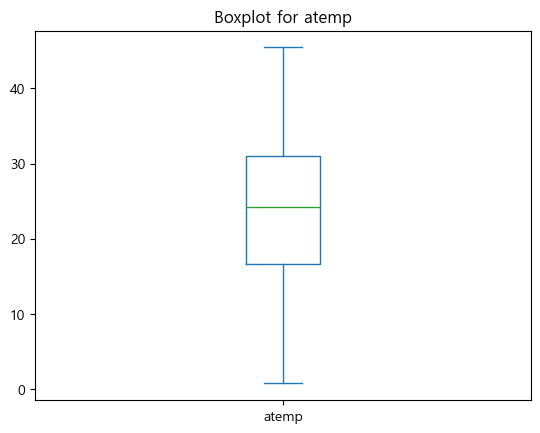

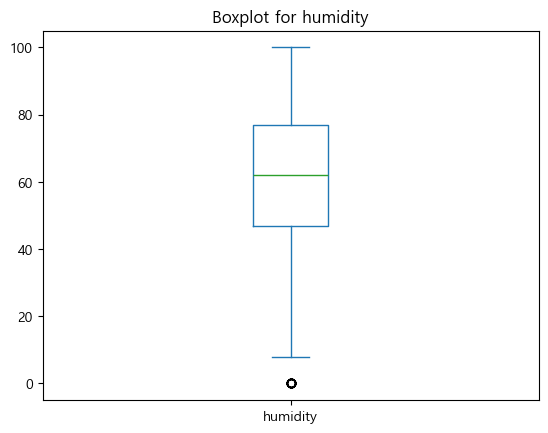

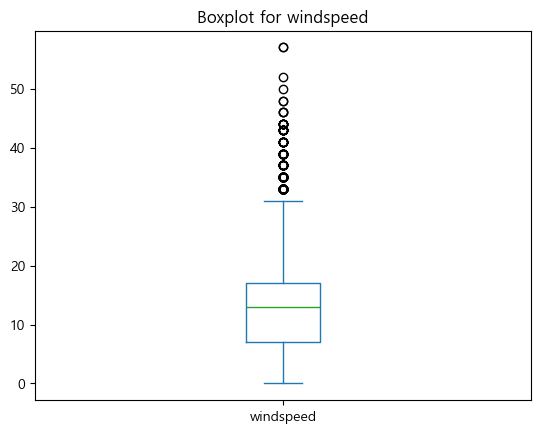

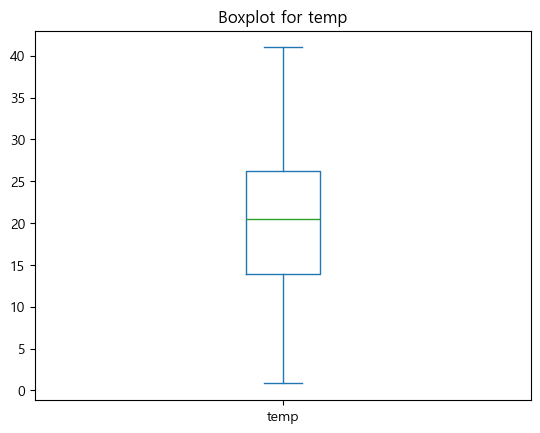

In [27]:
def anomaly_distribution(df, columns): # 이상치 확인
    """
    주어진 DataFrame에서 지정된 열에 대해 박스플롯 생성
    """
    try:
        if isinstance(columns, list):
            for col in columns:
                plt.figure()
                df[col].plot.box()
                plt.title(f'Boxplot for {col}')
                plt.show()
        else:
            plt.figure()
            df[columns].plot.box()
            plt.title(f'Boxplot for {columns}')
            plt.show()
    except KeyError as e:
        print(f"Error: {e} - Ensure the column exists in the DataFrame.")
    except Exception as e:
        print(f"Unexpected error: {e}")


# 다중 열 박스플롯
anomaly_distribution(train_df, ['atemp', 'humidity', 'windspeed','temp']) # 훈련데이터
# anomaly_distribution(test_df, ['atemp', 'humidity', 'windspeed'])  # 평가데이터

- 습도와 풍속 컬럼에 이상치를 그래프 상으로 확인할수 있다.
- 각 컬럼의 이상치 확인하기

In [29]:
train_df['humidity'].describe()

count    10886.000000
mean        61.886460
std         19.245033
min          0.000000
25%         47.000000
50%         62.000000
75%         77.000000
max        100.000000
Name: humidity, dtype: float64

In [30]:
train_df['humidity'].value_counts()

humidity
88    368
94    324
83    316
87    289
70    259
     ... 
8       1
10      1
97      1
96      1
91      1
Name: count, Length: 89, dtype: int64

In [31]:
q3 = train_df['humidity'].quantile(0.75)
q1 = train_df['humidity'].quantile(0.25)

iqr = q3 - q1

upper_limit = q3 + 1.5 * iqr
lower_limit = q1 - 1.5 * iqr

train_df[(train_df['humidity'] > upper_limit) | (train_df['humidity'] < lower_limit)]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
1091,2011-03-10 00:00:00,1,0,1,3,13.94,15.910,0,16.9979,3,0,3
1092,2011-03-10 01:00:00,1,0,1,3,13.94,15.910,0,16.9979,0,2,2
1093,2011-03-10 02:00:00,1,0,1,3,13.94,15.910,0,16.9979,0,1,1
1094,2011-03-10 05:00:00,1,0,1,3,14.76,17.425,0,12.9980,1,2,3
1095,2011-03-10 06:00:00,1,0,1,3,14.76,16.665,0,22.0028,0,12,12
1096,2011-03-10 07:00:00,1,0,1,3,15.58,19.695,0,15.0013,1,36,37
1097,2011-03-10 08:00:00,1,0,1,3,15.58,19.695,0,19.0012,1,43,44
1098,2011-03-10 09:00:00,1,0,1,3,16.40,20.455,0,15.0013,1,23,24
1099,2011-03-10 10:00:00,1,0,1,3,16.40,20.455,0,11.0014,0,17,17
1100,2011-03-10 11:00:00,1,0,1,3,16.40,20.455,0,16.9979,6,5,11


In [32]:
train_df[(train_df['humidity'] == 0)].shape[0]/train_df[(train_df['humidity'] > 0)].shape[0]

0.002025036818851252

- 습도 컬럼의 경우 습도가 0인 경우가 이상치 값으로 나왔음
- 습도가 0일 가능성은 매우 낮고, 거의 현실적으로 존재하지 않기때문에 이상치를 제거한다

In [39]:
train_df = train_df[(train_df['humidity'] > 0)]

In [41]:
train_df[(train_df['humidity'] > upper_limit) | (train_df['humidity'] < lower_limit)]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count


- windspeed 이상치 확인

In [44]:
train_df['windspeed'].value_counts().sort_index()

windspeed
0.0000     1313
6.0032      871
7.0015     1034
8.9981     1119
11.0014    1056
12.9980    1041
15.0013     955
16.9979     819
19.0012     675
19.9995     491
22.0028     370
23.9994     273
26.0027     234
27.9993     187
30.0026     111
31.0009      89
32.9975      80
35.0008      58
36.9974      22
39.0007      26
40.9973      11
43.0006      12
43.9989       8
46.0022       3
47.9988       2
50.0021       1
51.9987       1
56.9969       2
Name: count, dtype: int64

In [46]:
q3 = train_df['windspeed'].quantile(0.75)
q1 = train_df['windspeed'].quantile(0.25)

iqr = q3 - q1

upper_limit = q3 + 1.5 * iqr
lower_limit = q1 - 1.5 * iqr

train_df[(train_df['windspeed'] > upper_limit) | (train_df['windspeed'] < lower_limit)]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
175,2011-01-08 14:00:00,1,0,0,1,8.20,8.335,32,32.9975,12,83,95
178,2011-01-08 17:00:00,1,0,0,1,6.56,6.060,37,36.9974,5,64,69
194,2011-01-09 09:00:00,1,0,0,1,4.92,3.790,46,35.0008,0,19,19
196,2011-01-09 11:00:00,1,0,0,1,6.56,6.060,40,35.0008,2,47,49
265,2011-01-12 12:00:00,1,0,1,1,8.20,7.575,47,39.0007,3,52,55
...,...,...,...,...,...,...,...,...,...,...,...,...
10013,2012-11-02 14:00:00,4,0,1,2,16.40,20.455,40,32.9975,63,199,262
10154,2012-11-08 12:00:00,4,0,1,1,16.40,20.455,24,32.9975,33,202,235
10263,2012-11-13 01:00:00,4,0,1,3,18.04,21.970,88,43.0006,0,5,5
10540,2012-12-05 14:00:00,4,0,1,1,19.68,23.485,33,32.9975,39,179,218


In [48]:
outliers = train_df[(train_df['windspeed'] > upper_limit) | (train_df['windspeed'] < lower_limit)]

In [50]:
outliers.shape[0]

226

In [52]:
outliers.shape[0]/(train_df.shape[0]-226)

0.021244594848655762

In [54]:
outliers['windspeed'].value_counts()

windspeed
32.9975    80
35.0008    58
39.0007    26
36.9974    22
43.0006    12
40.9973    11
43.9989     8
46.0022     3
56.9969     2
47.9988     2
51.9987     1
50.0021     1
Name: count, dtype: int64

In [56]:
outliers['count'].sum()

43605

In [58]:
outliers['count'].mean()

192.94247787610618

In [60]:
upper_limit

31.992500000000003

- upper_limit 은 대략 32로 32 m/s 의 풍속이 넘는 데이터를 이상치로 판단 했다.
- 풍속 32 이상에서 자전거의 대여 건수가 43605건 존재하지만 사실 풍속 32 m/s 는 태풍급 강풍으로 외출 자체가 위험하다.
- 따라서 풍속 32 m/s 이상의 이상치 데이터를 삭제한다

In [63]:
train_df = train_df[(train_df['windspeed'] <= upper_limit)]

In [65]:
train_df[(train_df['windspeed'] > upper_limit) | (train_df['windspeed'] < lower_limit)]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count


### 1. 특정 시간대의 자전거 대여 패턴은 무엇인가요?

In [68]:
# 시간대별 자전거 대여 패턴

In [70]:
train_df.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [72]:
train_df['datetime'] = pd.to_datetime(train_df['datetime']) # datetime 타입으로 바꾸기

In [74]:
# train_df['datetime'].dt.hour	시간 (0~23시)
# train_df['datetime'].dt.day	일
# train_df['datetime'].dt.month	월
# train_df['datetime'].dt.year	연도
# train_df['datetime'].dt.weekday	요일 (0: 월, 6: 일)
# train_df['datetime'].dt.date	날짜만 추출

In [76]:
train_df['datetime'].dtypes

dtype('<M8[ns]')

In [78]:
# train_df['datetime'].dt.hour 별 casual	registered	count 각 컬럼의 총합
train_df['hour'] = train_df['datetime'].dt.hour
hourly_sum = train_df.groupby('hour')[['casual', 'registered', 'count']].sum()

In [80]:
hourly_sum

,casual,registered,count
hour,,,
0,4683,20373,25056
1,2953,12376,15329
2,2156,8070,10226
3,1159,3898,5057
4,554,2264,2818
5,654,8188,8842
6,1879,32609,34488
7,4959,91950,96909
8,9665,152762,162427


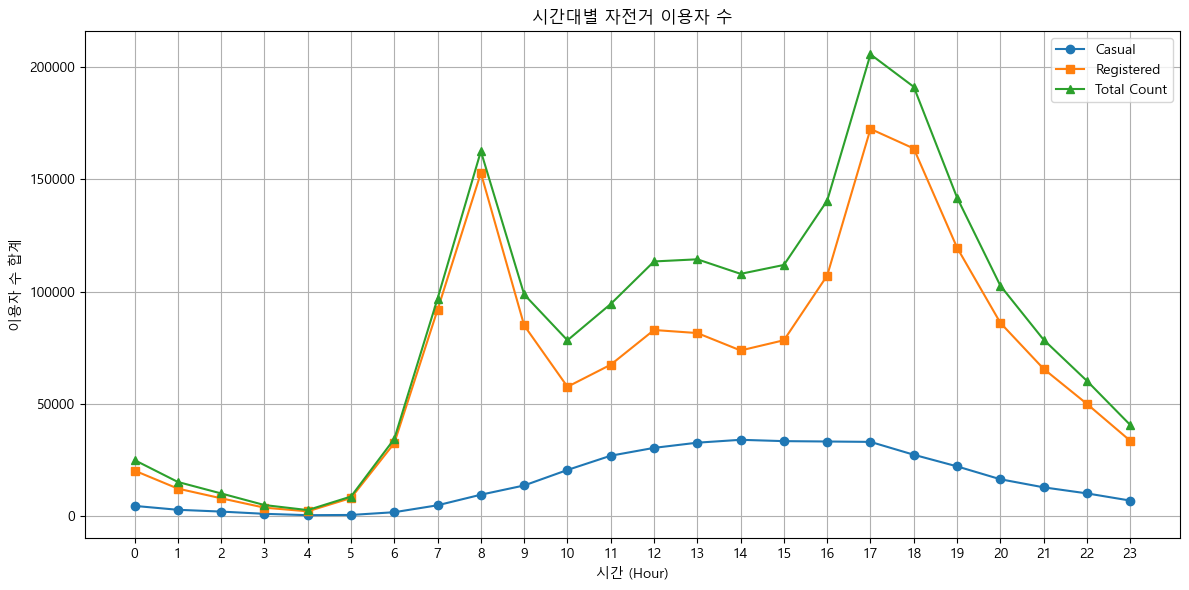

In [82]:
plt.figure(figsize=(12, 6))

plt.plot(hourly_sum.index, hourly_sum['casual'], label='Casual', marker='o')
plt.plot(hourly_sum.index, hourly_sum['registered'], label='Registered', marker='s')
plt.plot(hourly_sum.index, hourly_sum['count'], label='Total Count', marker='^')

plt.title('시간대별 자전거 이용자 수')
plt.xlabel('시간 (Hour)')
plt.ylabel('이용자 수 합계')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [84]:
hourly_mean = train_df.groupby('hour')[['casual', 'registered', 'count']].mean()

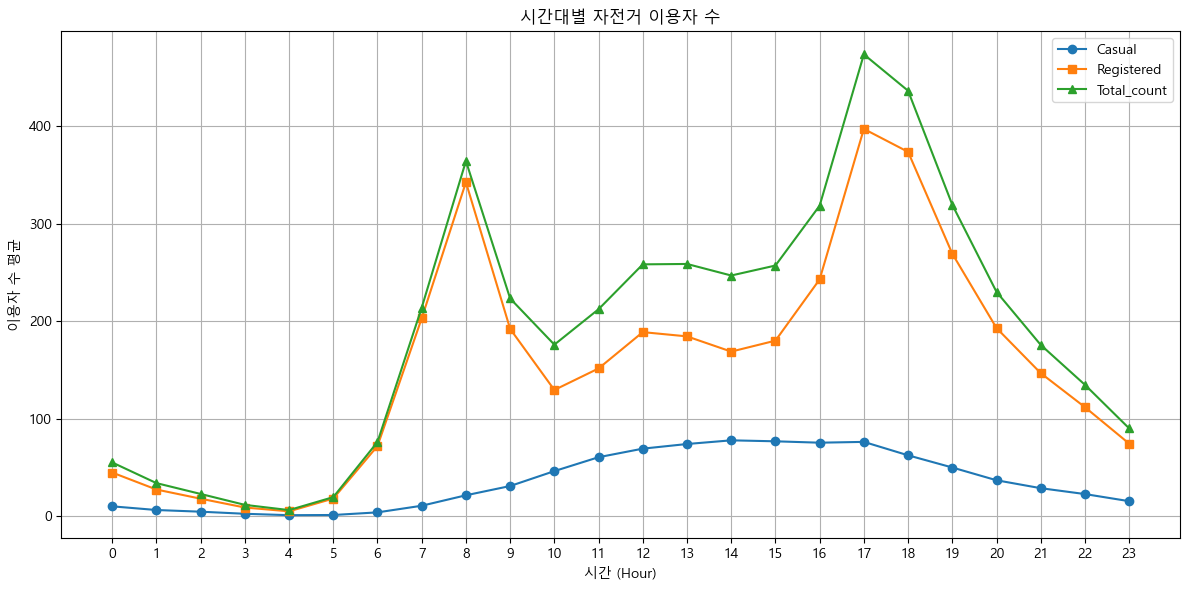

In [86]:
plt.figure(figsize=(12, 6))

plt.plot(hourly_mean.index, hourly_mean['casual'], label='Casual', marker='o')
plt.plot(hourly_mean.index, hourly_mean['registered'], label='Registered', marker='s')
plt.plot(hourly_mean.index, hourly_mean['count'], label='Total_count', marker='^')

plt.title('시간대별 자전거 이용자 수')
plt.xlabel('시간 (Hour)')
plt.ylabel('이용자 수 평균')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

- 출근 시간대인 오전 8시에 자전거 이용량이 늘어나고, 퇴근시간대인 17시에 자전거 이용량이 늘어난다
- 평균적으로 등록된 사용자의 이용량이 미등록 사용자보다 많고, 자전거를 출퇴근에 사용하는 이용자는 보통 등록된 사용자들이다
- 미등록 자용자의 경우 오전 6시부터 이용자가 순차적으로 늘어서 14시쯤에 가장 많은 자전거를 대여하고 17시 부터 이용량이 줄기시작해서 순차적으로 줄어든다

- 이용한 시간대의 크기와 자전거 사용량과의 상관 계수

In [90]:
train_df['registered'].sum()

1657348

In [92]:
train_df['count'].sum()

2041248

In [94]:
train_df['registered'].sum()/train_df['count'].sum()

0.81192878082428

In [96]:
df = train_df[(train_df['hour'] == 7) | (train_df['hour'] == 8) | (train_df['hour'] == 17) | (train_df['hour'] == 18)]

In [98]:
df['count'].sum()/2041248

0.3213284226120491

In [100]:
correlation = train_df[['hour', 'count']].corr()

In [102]:
correlation

,hour,count
hour,1.000000,0.404701
count,0.404701,1.000000


시간이 늦을수록 대여량이 증가하는 경향이 있음  

하지만 시간의 크기보단 특정 시간대에 이용자수가 증가하는 모습을 보이기 때문에 원핫 인코딩을 통해 특정 시간대와 count 와의 상관 관계를 구해봄 

In [105]:
# 원핫 인코딩으로 시간대별 효과 확인하기

hour_dummies = pd.get_dummies(train_df['hour'], prefix='hour', drop_first=False)

df_corr = pd.concat([hour_dummies, train_df['count']], axis=1)
corr = df_corr.corr()

# hour별 상관관계만 필터링해서 보기
hour_corr = corr['count'].filter(like='hour_').sort_values(ascending=False)
print(hour_corr)

hour_17    0.320489
hour_18    0.279393
hour_8     0.198885
hour_19    0.146835
hour_16    0.145266
hour_13    0.076799
hour_12    0.076068
hour_15    0.074329
hour_14    0.062824
hour_20    0.044140
hour_9     0.036170
hour_7     0.025653
hour_11    0.023593
hour_10   -0.018278
hour_21   -0.018603
hour_22   -0.065864
hour_23   -0.118014
hour_6    -0.134346
hour_0    -0.158927
hour_1    -0.182715
hour_2    -0.194443
hour_5    -0.198884
hour_3    -0.203150
hour_4    -0.210967
Name: count, dtype: float64


C:\Users\82104\AppData\Local\Temp\ipykernel_8892\4052843073.py:7: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
C:\Users\82104\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


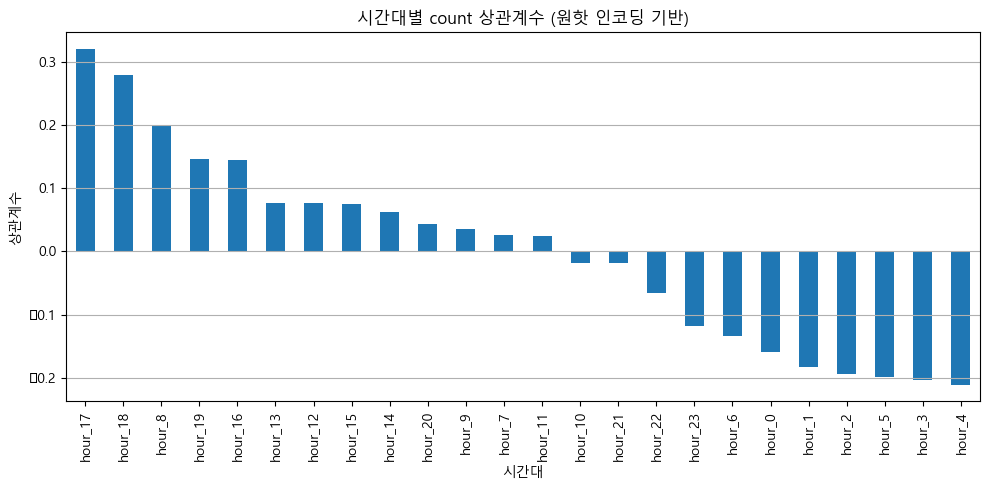

In [107]:
plt.figure(figsize=(10, 5))
hour_corr.plot(kind='bar')
plt.title('시간대별 count 상관계수 (원핫 인코딩 기반)')
plt.ylabel('상관계수')
plt.xlabel('시간대')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

- 출퇴근시간대인 17시, 18시, 8시 순으로 양의 상관관계가 컸으며, 반면 새벽 시간인 4시 3시 5시 순으로 음의 상관관계를 보여주었다
- 그렇다면 일별 /월별/년도별 자전거 대여량과 상관관계가 높은 변수가 있을지 살펴보자

In [110]:
train_df['year'] = train_df['datetime'].dt.year
df =  train_df.groupby('year')['count'].mean()

<Axes: xlabel='year'>

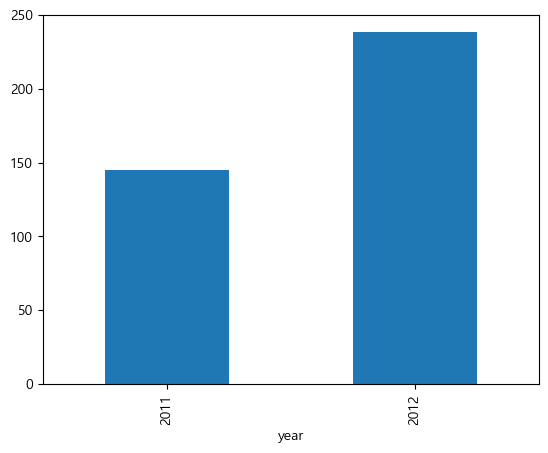

In [112]:
df.plot(kind='bar')

<Axes: xlabel='month'>

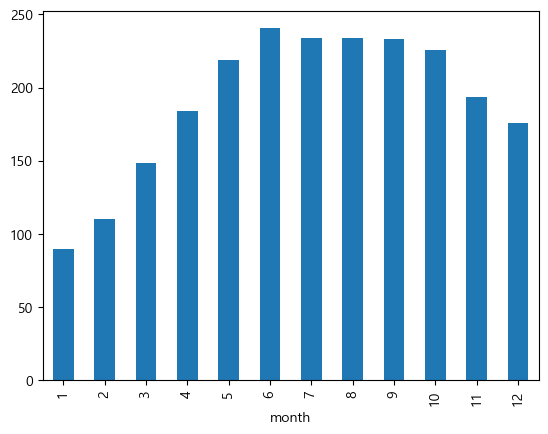

In [114]:
train_df['month'] = train_df['datetime'].dt.month
df =  train_df.groupby('month')['count'].mean()
df.plot(kind='bar')

<Axes: xlabel='day'>

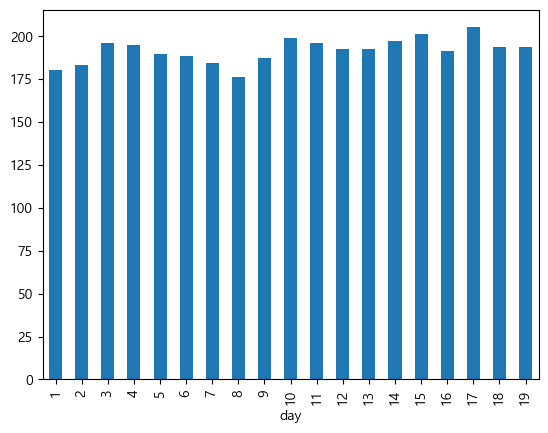

In [116]:
train_df['day'] = train_df['datetime'].dt.day
df =  train_df.groupby('day')['count'].mean()
df.plot(kind='bar')

In [117]:
# 원핫 인코딩으로 일별 효과 확인하기

day_dummies = pd.get_dummies(exercise_data['day'], prefix='day', drop_first=False)

df_corr = pd.concat([day_dummies, exercise_data['count']], axis=1)
corr = df_corr.corr()

# day별 상관관계만 필터링해서 보기
day_corr = corr['count'].filter(like='day_').sort_values(ascending=False)
print(day_corr)

NameError: name 'exercise_data' is not defined

In [119]:
# 원핫 인코딩으로 월별 효과 확인하기

month_dummies = pd.get_dummies(exercise_data['month'], prefix='month', drop_first=False)

df_corr = pd.concat([month_dummies, exercise_data['count']], axis=1)
corr = df_corr.corr()

# day별 상관관계만 필터링해서 보기
month_corr = corr['count'].filter(like='month_').sort_values(ascending=False)
print(month_corr)

NameError: name 'exercise_data' is not defined

In [121]:
year_dummies = pd.get_dummies(exercise_data['year'], prefix='year', drop_first=False)

df_corr = pd.concat([year_dummies, exercise_data['count']], axis=1)
corr = df_corr.corr()

# day별 상관관계만 필터링해서 보기
year_corr = corr['count'].filter(like='year_').sort_values(ascending=False)
print(year_corr)

NameError: name 'exercise_data' is not defined

- 년도 > 월 > 일 순으로 자전거 대여량과 상관관계가 있었고, 특히 일과는 상관관계가 낮았다

### 2. 날씨 변수와 자전거 대여 수요 간의 상관관계는 무엇인가요?

날씨 상황 (1: 맑음, 2: 구름낌/안개, 3: 약간의 비/눈, 4: 폭우/폭설)

In [126]:
train_df['weather'].value_counts(dropna=False)

weather
1    7039
2    2793
3     805
4       1
Name: count, dtype: int64

In [128]:
# 날씨별  casual registered count 컬럼의 평균
weather_mean = train_df.groupby('weather')[['casual', 'registered', 'count']].mean()

In [130]:
weather_mean

,casual,registered,count
weather,,,
1,40.332434,165.110811,205.443245
2,30.747583,147.630147,178.377730
3,17.535404,102.663354,120.198758
4,6.000000,158.000000,164.000000


In [132]:
train_df['weather'].dtypes

dtype('int64')

In [134]:
print(weather_mean.index)

Index([1, 2, 3, 4], dtype='int64', name='weather')


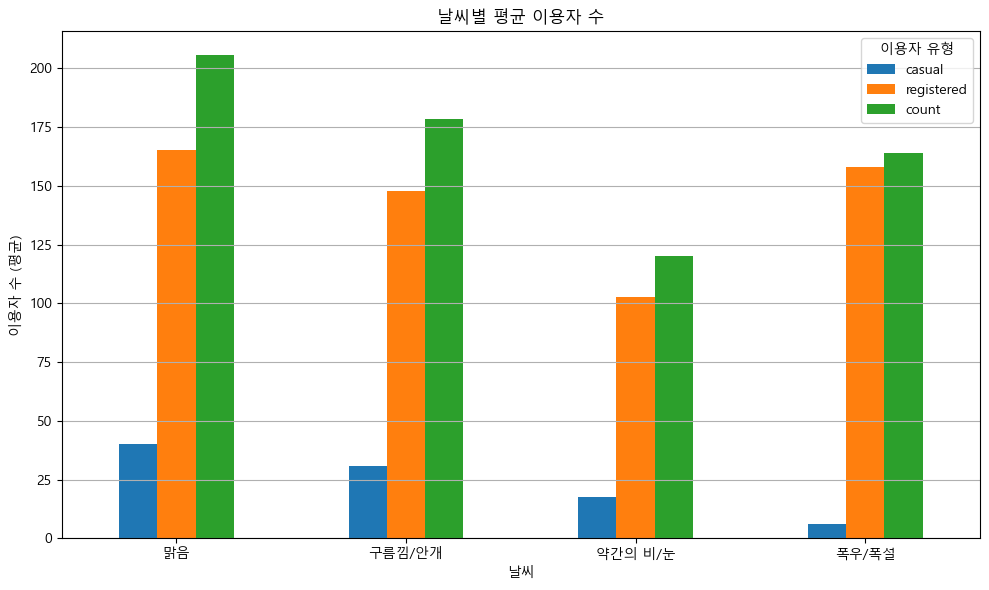

In [136]:
weather_labels = {
    1: '맑음',
    2: '구름낌/안개',
    3: '약간의 비/눈',
    4: '폭우/폭설'
}
weather_mean.index = weather_mean.index.map(weather_labels)

# 시각화
weather_mean.plot(kind='bar', figsize=(10, 6))

plt.title('날씨별 평균 이용자 수')
plt.xlabel('날씨')
plt.ylabel('이용자 수 (평균)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(title='이용자 유형')
plt.tight_layout()
plt.show()

In [138]:
weather_sum = train_df.groupby('weather')[['casual', 'registered', 'count']].sum()

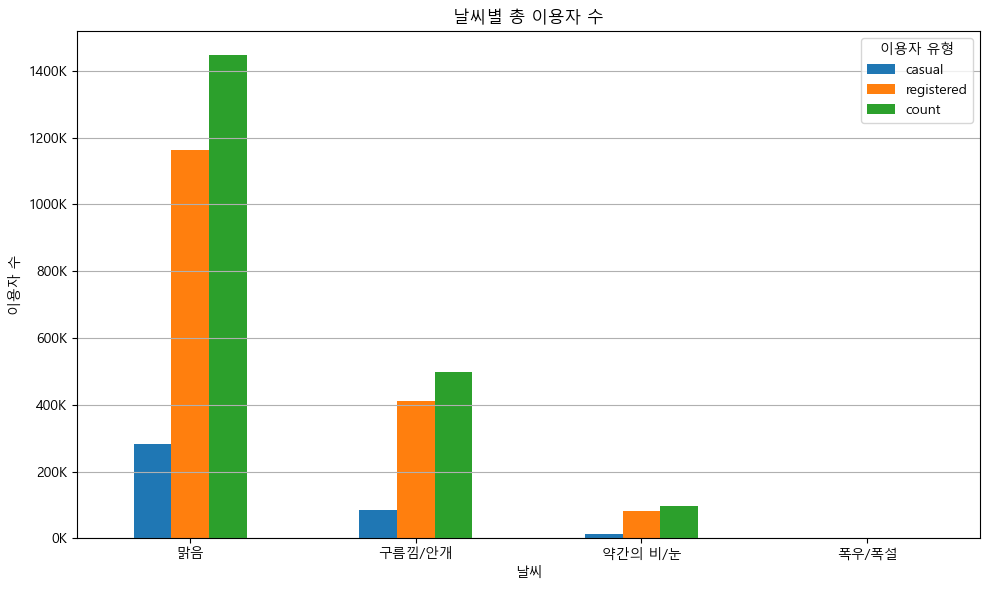

In [140]:
weather_labels = {
    1: '맑음',
    2: '구름낌/안개',
    3: '약간의 비/눈',
    4: '폭우/폭설'
}
weather_sum.index = weather_sum.index.map(weather_labels)

import matplotlib.ticker as ticker

# 시각화
ax = weather_sum.plot(kind='bar', figsize=(10, 6))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}K'))

plt.title('날씨별 총 이용자 수')
plt.xlabel('날씨')
plt.ylabel('이용자 수')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(title='이용자 유형')
plt.tight_layout()
plt.show()

- 폭우/폭설일 경우가 약간의 비/눈 인 경우보다 평균 이용자수가 많고, 이용자수는 거의 없는 상태에 이상함을 느끼고 폭우/폭설 데이터를 확인

In [143]:
train_df[train_df['weather'] == 4]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,year,month,day
5631,2012-01-09 18:00:00,1,0,1,4,8.2,11.365,86,6.0032,6,158,164,18,2012,1,9


In [145]:
train_df[train_df['weather'] == 4]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,year,month,day
5631,2012-01-09 18:00:00,1,0,1,4,8.2,11.365,86,6.0032,6,158,164,18,2012,1,9


- 폭우 폭설인 경우의 데이터가 1건이고, 나중에 원핫 인코딩을 했을때 컬럼을 하나더 생성 해야 하기때문에 폭우/폭설 데이터 삭제

In [149]:
train_df = train_df[train_df['weather'] !=4]
# train_df.drop(train_df[train_df['weather'] == 4].index, inplace=True)

In [151]:
train_df[train_df['weather'] == 4]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,year,month,day


In [153]:
# weather 과 count와의 상관 관계
weather_dummies = pd.get_dummies(train_df['weather'], prefix='weather', drop_first=False)

# count와 합치기
df_corr = pd.concat([weather_dummies, train_df['count']], axis=1)

# 상관계수 계산
corr = df_corr.corr()
print(corr['count'].sort_values(ascending=False))

count        1.000000
weather_1    0.104633
weather_2   -0.044473
weather_3   -0.113179
Name: count, dtype: float64


In [155]:
weather_mean = train_df.groupby('weather')['count'].mean()
print(weather_mean)

weather
1    205.443245
2    178.377730
3    120.198758
Name: count, dtype: float64


- 날씨가 맑음 , 구름낌/안개 , 약간의 비/눈 순으로 평균 자전거 대여량이 많다
- 낡은 날씨는 양의 상관 관계, 그리고 구름낌/안개 혹은 비/눈 은 음의 상관 관계를 가진다
- 자전거 대여량은 날씨에 어느정도 영향을 받는다

In [158]:
# temp , atemp, humidity, windspeed

In [160]:
train_df[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()['count'].sort_values(ascending=False)

count        1.000000
temp         0.390949
atemp        0.386254
windspeed    0.115136
humidity    -0.333548
Name: count, dtype: float64

In [162]:
# 실제 온도와 체감온도의 차이와 count와의 상관 관계

In [164]:
train_df['difference'] = train_df['temp'] - train_df['atemp']

In [166]:
train_df['difference'].corr(train_df['count'])

-0.13982250455887263

In [168]:
train_df['difference_abs'] = (train_df['temp'] - train_df['atemp']).abs()

In [169]:
# 온도차의 절대값과 count 와의 상관 관계
train_df['difference'].abs().corr(train_df['count'])

0.20107107986645933

체감온도의 실제온도의 차이보다 절대값을 한 컬럼이 자전거 이용량과의 연관성이 더 높았다.

- 사실 여기서 모델링 할때 굳이 temp와 atemp 둘다 넣을 필요가 있을까? 하는 궁금증이 생김
- 그리고 하나만 모델링에 쓴다면 temp와 atemp중 뭐가더 좋을까 고민을 했는데 atemp가 더 좋지 않을까 하는 생각을함
- 그리고 상관 계수가 더 높게 나온 온도차의 절대값 컬럼을 모델링에 쓰는게 더좋지 않을까 하는 생각을 함

C:\Users\82104\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
C:\Users\82104\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


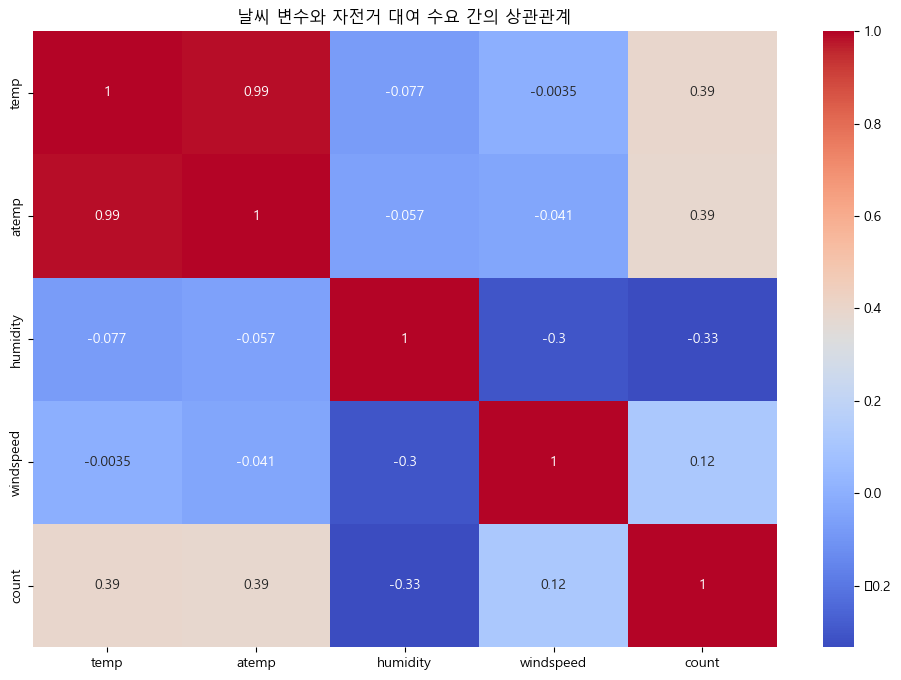

In [174]:
plt.figure(figsize=(12, 8))
sns.heatmap(train_df[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr(), annot=True, cmap='coolwarm')
plt.title('날씨 변수와 자전거 대여 수요 간의 상관관계')
plt.show()

- 실측온도와 체감온도가 올라갈수록 자전거 대여량이 증가하는 경향을 보였지만,
지나치게 높은 온도에서는 수요가 감소할 수도 있어 온도와 대여량 간의 관계는 완전히 선형적이지 않을 가능성이 크다
- 습도가 높을수록 대여량은 감소하는 음의 상관관계를 보인다.
- 바람 속도와 대여량의 관계는 아주 약한 양의 상관 관계를 보인다

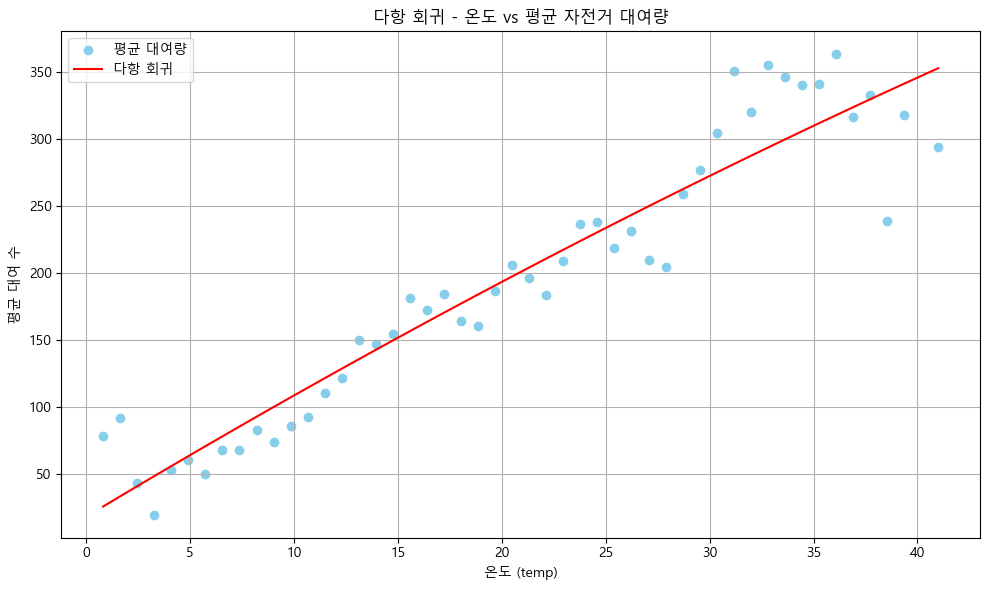

RMSLE: 0.2814


In [178]:
# 1. temp별 평균 count 그래프
temp_mean = train_df.groupby('temp')['count'].mean().reset_index()

X = temp_mean[['temp']]  # 독립 변수 
y = temp_mean['count']   # 종속 변수

# 2. 다항 특성 생성
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# 3. 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X_poly, y)

# 4. 예측값 계산
y_pred = model.predict(X_poly)

# 5. 시각화
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='skyblue', label='평균 대여량')
plt.plot(X, y_pred, color='red', label='다항 회귀')
plt.title('다항 회귀 - 온도 vs 평균 자전거 대여량')
plt.xlabel('온도 (temp)')
plt.ylabel('평균 대여 수')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 6. 성능 확인 (RMSLE)
y_pred = np.maximum(y_pred, 0)  # 음수 방지!
rmsle = np.sqrt(mean_squared_log_error(y, y_pred))
print(f"RMSLE: {rmsle:.4f}")

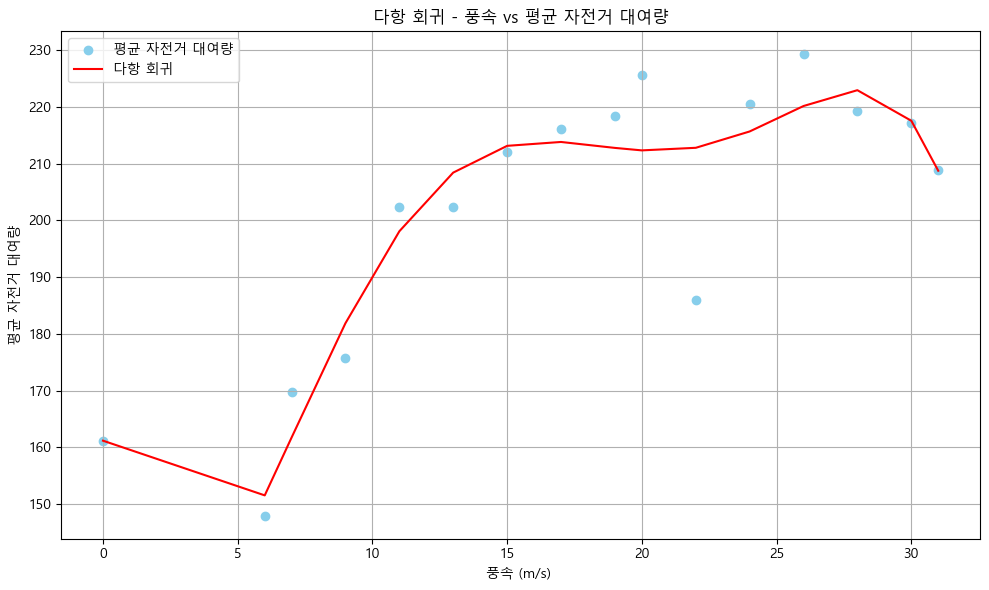

RMSLE: 0.0435


In [180]:
# 1. windspeed별 평균 count 그래프
windspeed_mean = train_df.groupby('windspeed')['count'].mean().reset_index()

X = windspeed_mean[['windspeed']] 
y = windspeed_mean['count']   

# 2. 다항 특성 생성
poly = PolynomialFeatures(degree=5, include_bias=False)
X_poly = poly.fit_transform(X)

# 3. 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X_poly, y)

# 4. 예측값 계산
y_pred = model.predict(X_poly)

# 5. 시각화
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='skyblue', label='평균 자전거 대여량')
plt.plot(X, y_pred, color='red', label='다항 회귀')
plt.title('다항 회귀 - 풍속 vs 평균 자전거 대여량')
plt.xlabel('풍속 (m/s) ')
plt.ylabel('평균 자전거 대여량')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 6. 성능 확인 (RMSLE)
y_pred = np.maximum(y_pred, 0)  # 음수 방지!
rmsle = np.sqrt(mean_squared_log_error(y, y_pred))
print(f"RMSLE: {rmsle:.4f}")

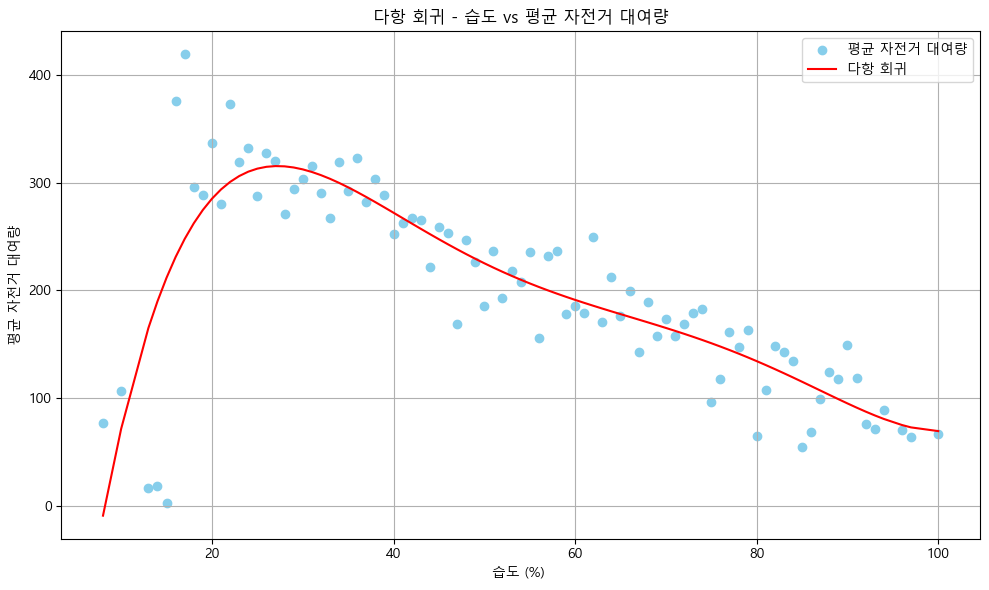

In [182]:
# 1. 습도 별 평균 count 그래프

humidity_mean = train_df.groupby('humidity')['count'].mean().reset_index()

X = humidity_mean[['humidity']]  # 독립 변수 
y = humidity_mean['count']   # 종속 변수

# 2. 다항 특성 생성
poly = PolynomialFeatures(degree=5, include_bias=False)
X_poly = poly.fit_transform(X)

# 3. 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X_poly, y)

# 4. 예측값 계산
y_pred = model.predict(X_poly)

# 5. 시각화
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='skyblue', label='평균 자전거 대여량')
plt.plot(X, y_pred, color='red', label='다항 회귀')
plt.title('다항 회귀 - 습도 vs 평균 자전거 대여량')
plt.xlabel('습도 (%) ')
plt.ylabel('평균 자전거 대여량')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 3. 계절별 자전거 대여 패턴의 차이는 무엇인가요?

In [185]:
season_sum = train_df.groupby('season')[['casual', 'registered', 'count']].sum()

In [187]:
season_sum

,casual,registered,count
season,,,
1,39650,256192,295842
2,126833,447905,574738
3,140803,491724,632527
4,76608,461369,537977


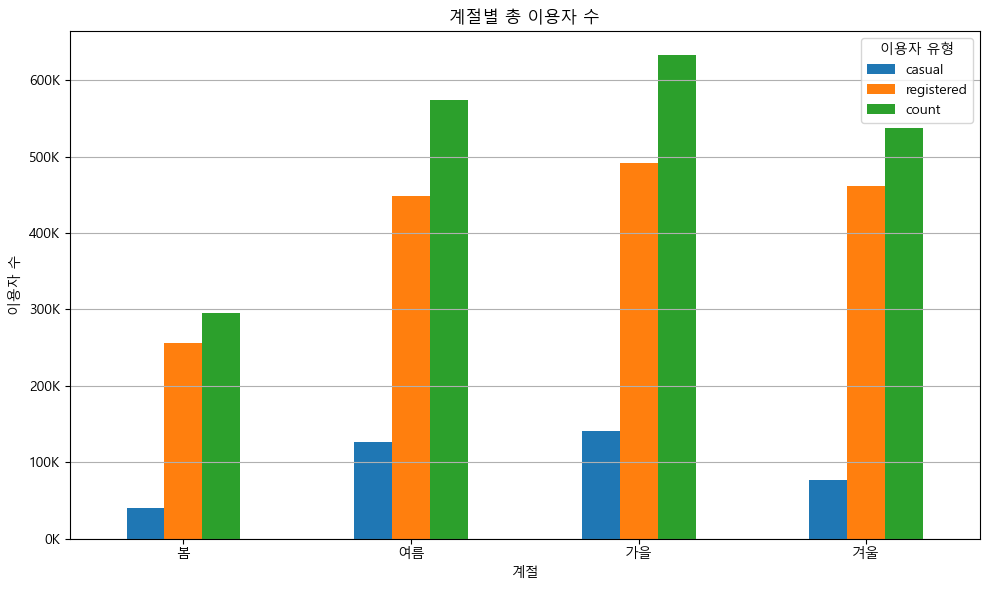

In [189]:
season_labels = {
    1: '봄',
    2: '여름',
    3: '가을',
    4: '겨울'
}
season_sum.index = season_sum.index.map(season_labels)

import matplotlib.ticker as ticker

# 시각화
ax = season_sum.plot(kind='bar', figsize=(10, 6))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}K'))

plt.title('계절별 총 이용자 수')
plt.xlabel('계절')
plt.ylabel('이용자 수')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(title='이용자 유형')
plt.tight_layout()
plt.show()

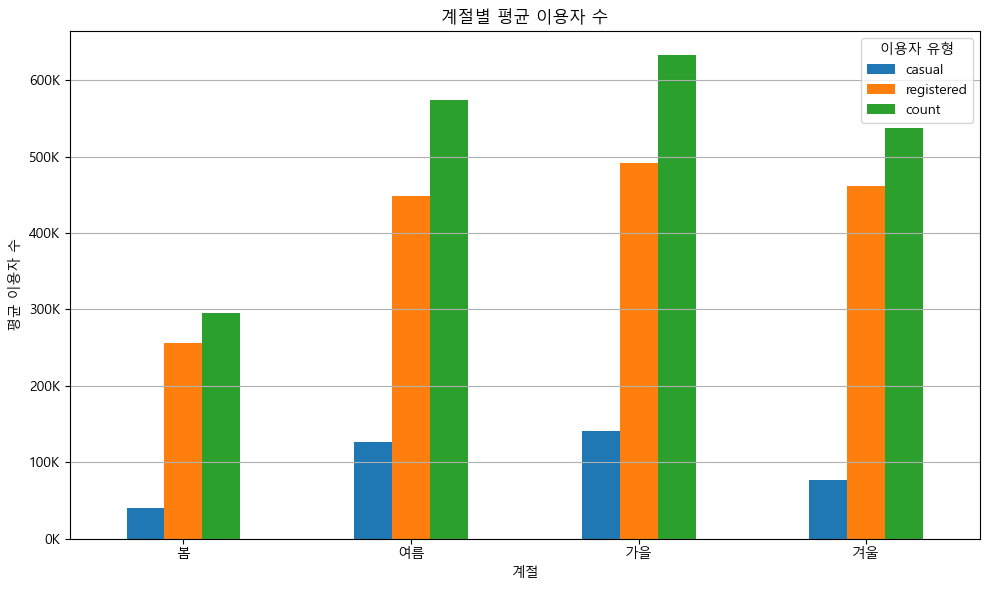

In [191]:
season_mean = train_df.groupby('season')[['casual', 'registered', 'count']].mean()

season_labels = {
    1: '봄',
    2: '여름',
    3: '가을',
    4: '겨울'
}
season_mean.index = season_mean.index.map(season_labels)

import matplotlib.ticker as ticker

# 시각화
ax = season_sum.plot(kind='bar', figsize=(10, 6))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}K'))

plt.title('계절별 평균 이용자 수')
plt.xlabel('계절')
plt.ylabel('평균 이용자 수')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(title='이용자 유형')
plt.tight_layout()
plt.show()

- 계절에 따라 자전거 대여량은 차이가 났는데 가을에 자전거 대여량이 가장 많고 가을 / 여름 / 겨울 /봄 순으로 자전거 총 대여량이 많다
 비교적 가을 여름 겨울의 간격이 적은데 반해 봄과 겨울의 자전거 대여량은 차이가 크다

In [194]:
# season 과 count와의 상관 관계
season_dummies = pd.get_dummies(train_df['season'], prefix='season', drop_first=False)

# count와 합치기
df_corr = pd.concat([season_dummies, train_df['count']], axis=1)

# 상관계수 계산
corr = df_corr.corr()
print(corr['count'].sort_values(ascending=False))

count       1.000000
season_3    0.134436
season_2    0.073700
season_4    0.021159
season_1   -0.233855
Name: count, dtype: float64


### 4. 주말과 평일의 자전거 대여 수요 차이는 무엇인가요?

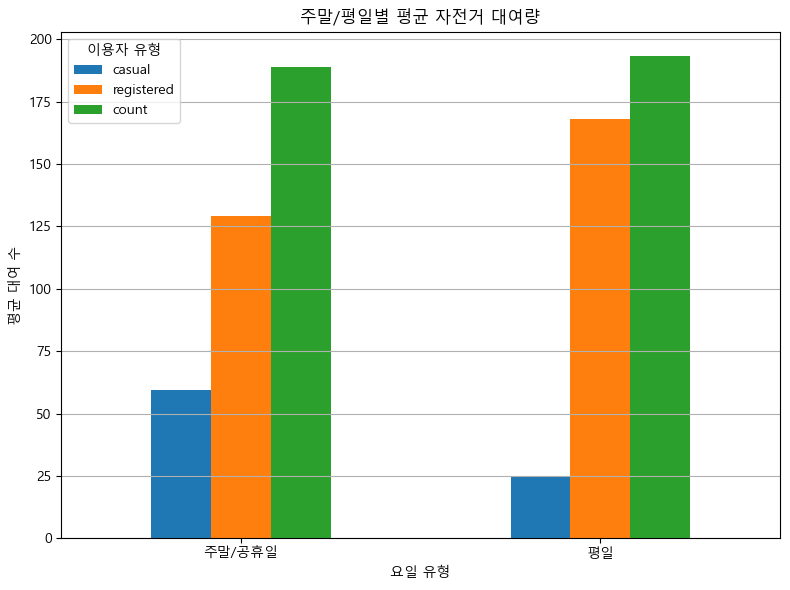

In [197]:
# 1. 주말 여부(workingday: 0=주말, 1=평일)별 평균 계산
weekend_avg = train_df.groupby('workingday')[['casual', 'registered', 'count']].mean()
weekend_avg.index = ['주말/공휴일', '평일']  # 보기 좋게 라벨링

# 2. 시각화
weekend_avg.plot(kind='bar', figsize=(8, 6))
plt.title('주말/평일별 평균 자전거 대여량')
plt.xlabel('요일 유형')
plt.ylabel('평균 대여 수')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(title='이용자 유형')
plt.tight_layout()
plt.show()

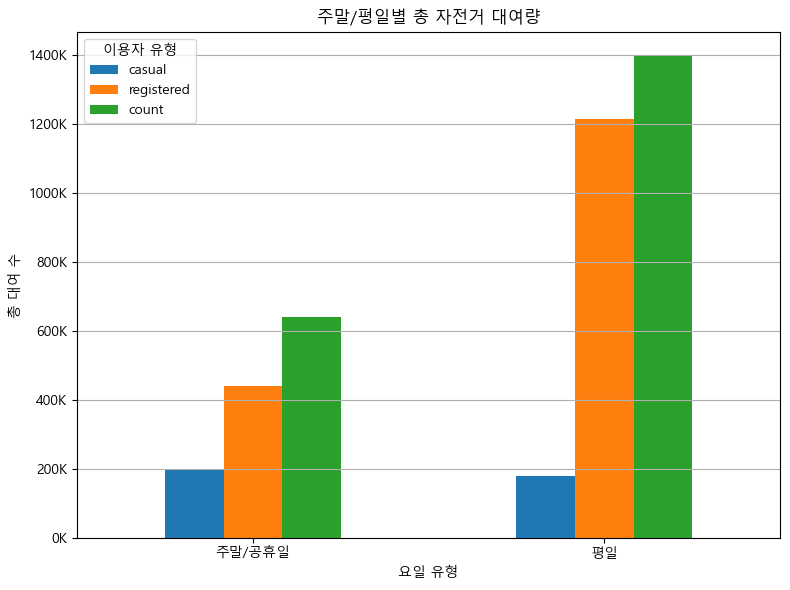

In [199]:
# 1. 주말 여부(workingday: 0=주말, 1=평일)별 평균 계산
weekend_sum = train_df.groupby('workingday')[['casual', 'registered', 'count']].sum()
weekend_sum.index = ['주말/공휴일', '평일']  # 보기 좋게 라벨링

# 2. 시각화
ax = weekend_sum.plot(kind='bar', figsize=(8, 6))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}K'))
plt.title('주말/평일별 총 자전거 대여량')
plt.xlabel('요일 유형')
plt.ylabel('총 대여 수')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(title='이용자 유형')
plt.tight_layout()
plt.show()

In [201]:
weekend_sum

,casual,registered,count
주말/공휴일,202077,440369,642446
평일,181817,1216821,1398638


In [203]:
print(181817	/1398638 * 100)
print(202077	/642446 * 100)

12.999575301114369
31.4543167830448


- 주말과 평일의 총 자전거 대여량의 평균은 비슷하다
- 평일의 등록하지 않은 사용자의 자전거 대여율은 13% 이지만 주말의 대여율은 31% 이다
- 평일에 비해 주말에 등록하지 않은 사람들의 자전거 대여율이 올라간다

In [206]:
# 상관계수
correlation = train_df[['workingday', 'count']].corr()
print(correlation)

            workingday     count
workingday    1.000000  0.011933
count         0.011933  1.000000


### 5. 자전거 대여 수요를 예측하기 위해 사용할 수 있는 가장 중요한 변수는 무엇인가요?

In [209]:
# 수치형 변수부터 골라서 상관 관계 계산
columns = [
    'season', 'holiday', 'workingday', 'weather',
    'temp', 'atemp', 'humidity', 'windspeed', 'count'
]

# 상관계수 계산
correlation = train_df[columns].corr()

# count와의 상관계수만 보기
count_corr = correlation['count'].sort_values(ascending=False)
print(count_corr)

count         1.000000
temp          0.390949
atemp         0.386254
season        0.158902
windspeed     0.115136
workingday    0.011933
holiday      -0.005610
weather      -0.126562
humidity     -0.333548
Name: count, dtype: float64


C:\Users\82104\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
C:\Users\82104\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


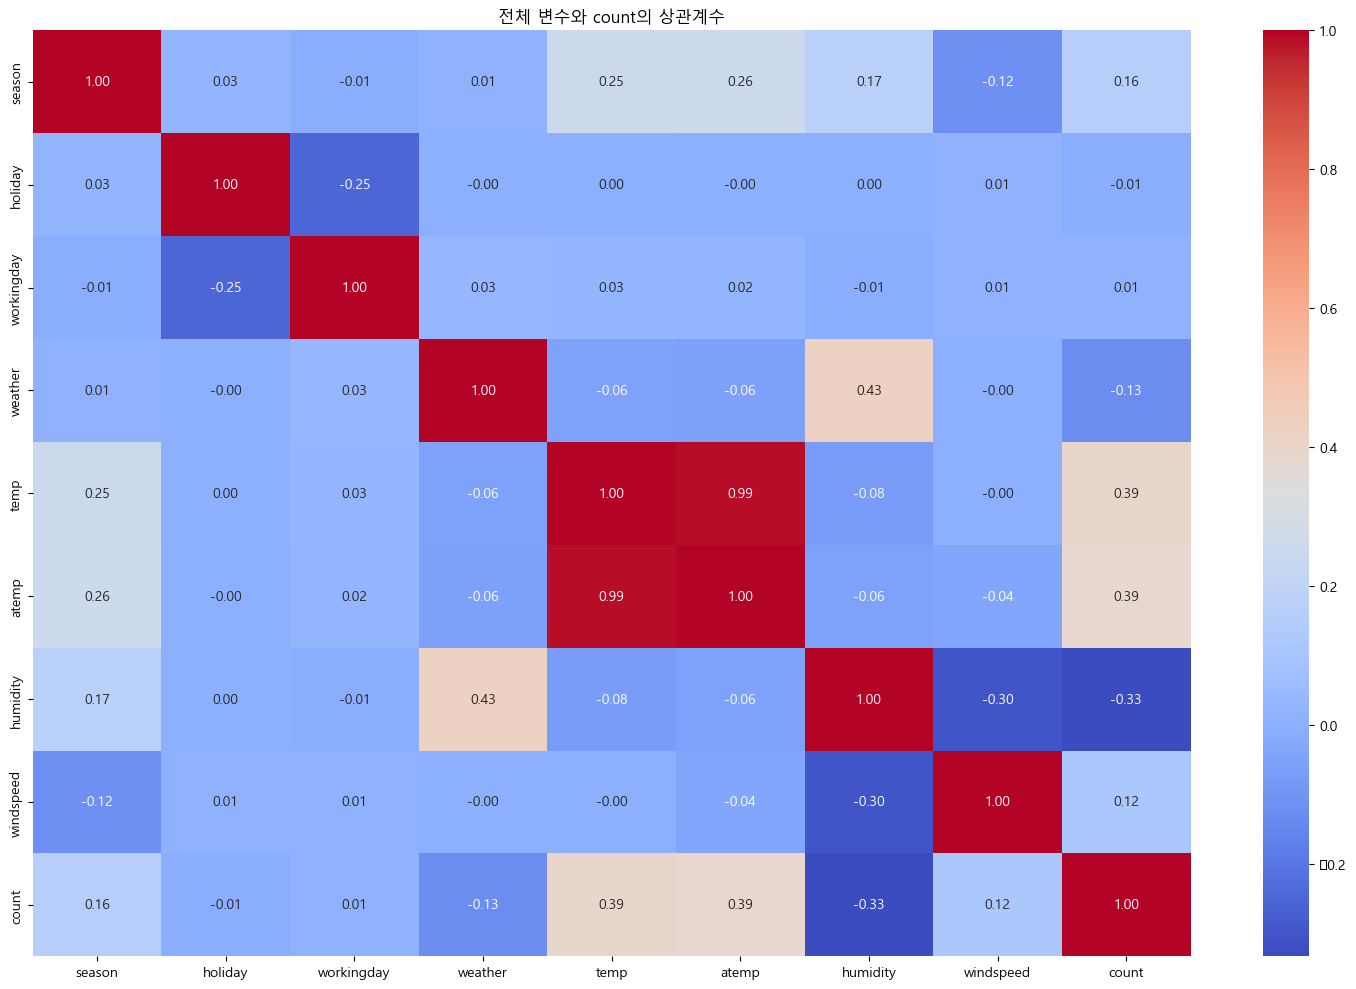

In [211]:
plt.figure(figsize=(15, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("전체 변수와 count의 상관계수")
plt.tight_layout()
plt.show()

- count 와의 상관 관계를 살펴 보았을때 시간 컬럼이 (hour = 0.40060) 자전거 수요에 가장큰 영향을 끼쳤고, 다음으로 temp 와 atemp 컬럼이 0.39로 영향을 끼쳤다.
- 하지만 시간 컬럼의 경우 시간의 크기가 count와 가장밀접한 상관관계를 나타내지만 데이터를 분석했을때 특정 시간대에서 자전거 이용량이 늘어나는 그래프를 보였음으로 시간을 구간을 나눠서 원핫 인코딩후 모델링을 하는것이 낫지 않을까 하는 생각을 함

<Axes: >

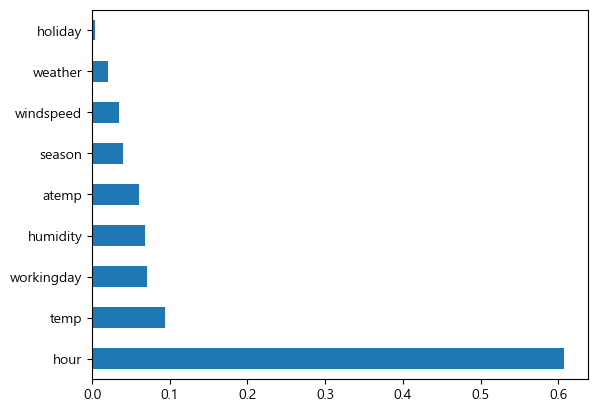

In [214]:
# 추가 학습 부분 ( 배우지 않은 부분)

from sklearn.ensemble import RandomForestRegressor

X = train_df[['hour', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']]
y = train_df['count']

model = RandomForestRegressor()
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='barh')

### 6. 자전거 대여 수요 예측 모델을 구축하고, 이를 기반으로 한 운영 전략을 제안해보세요.

### 모델링에 사용할 컬럼 정리

- 연관성이 낮았던 컬럼 삭제 : day , month(season 컬럼이 있음)

In [219]:
train_df = train_df.drop(columns=['day','month'])

- holiday 컬럼과 workingday 컬럼을 모두 써야할까?  

holday 컬럼은 공휴일 = 1 / 그리고 workingday 컬럼은 공휴일과 주말을 모두 1로 표시한다  
주말과 공휴일의 특징은 일을 하지 않는다는점이고 , 출근을 하지 않는다는점이다  
실제 그래프를 통해서 알아보자

In [222]:
train_df.groupby('holiday')['count'].mean()

holiday
0    192.060008
1    185.967213
Name: count, dtype: float64

In [224]:
train_df.groupby('workingday')['count'].mean()

workingday
0    188.732667
1    193.369003
Name: count, dtype: float64

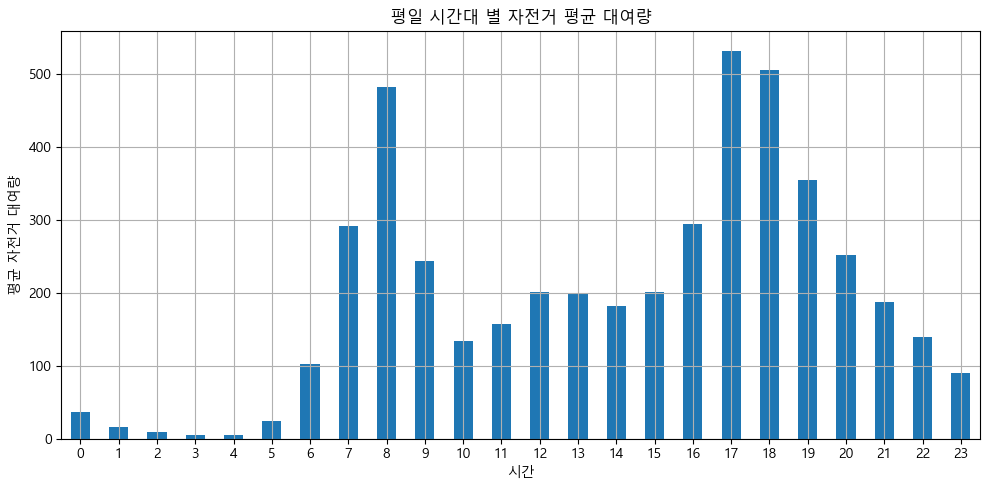

In [226]:
workingday_df = train_df[train_df['workingday'] == 1]
hourly_avg = workingday_df.groupby('hour')['count'].mean()
plt.figure(figsize=(10, 5))
hourly_avg.plot(kind='bar')
plt.title('평일 시간대 별 자전거 평균 대여량')
plt.xlabel('시간')
plt.ylabel('평균 자전거 대여량')
plt.grid(True)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

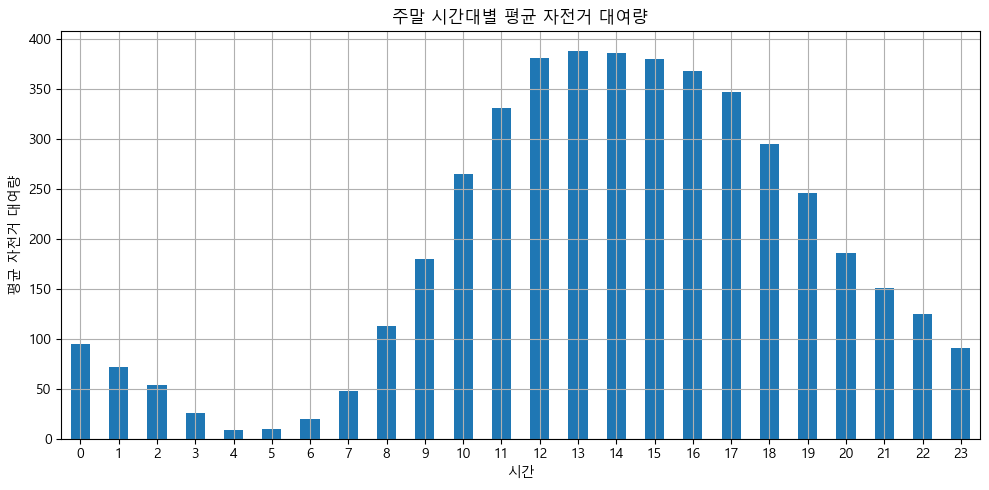

In [228]:
workingday_df = train_df[train_df['workingday'] == 0]
hourly_avg = workingday_df.groupby('hour')['count'].mean()
plt.figure(figsize=(10, 5))
hourly_avg.plot(kind='bar')
plt.title('주말 시간대별 평균 자전거 대여량')
plt.xlabel('시간')
plt.ylabel('평균 자전거 대여량')
plt.grid(True)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

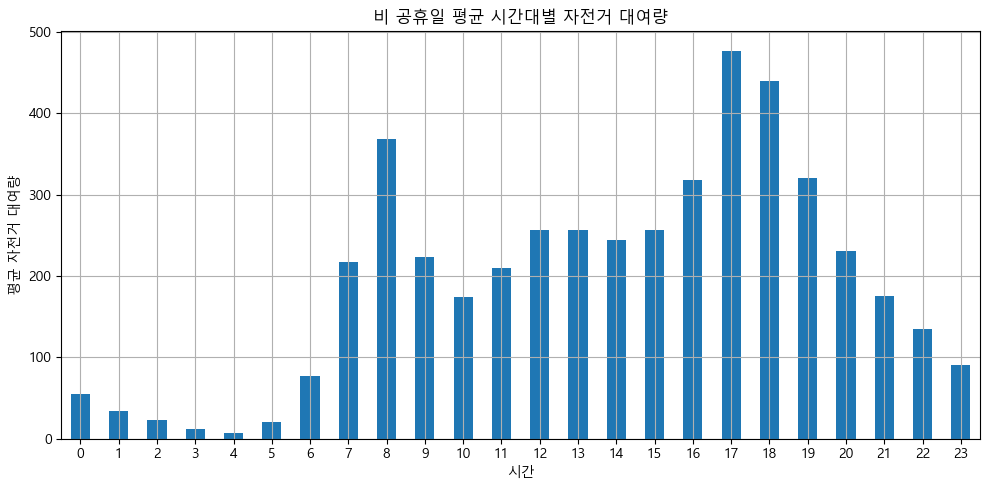

In [229]:
holiday_df = train_df[train_df['holiday'] == 0]
hourly_avg = holiday_df.groupby('hour')['count'].mean()
plt.figure(figsize=(10, 5))
hourly_avg.plot(kind='bar')
plt.title('비 공휴일 평균 시간대별 자전거 대여량')
plt.xlabel('시간')
plt.ylabel('평균 자전거 대여량')
plt.grid(True)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

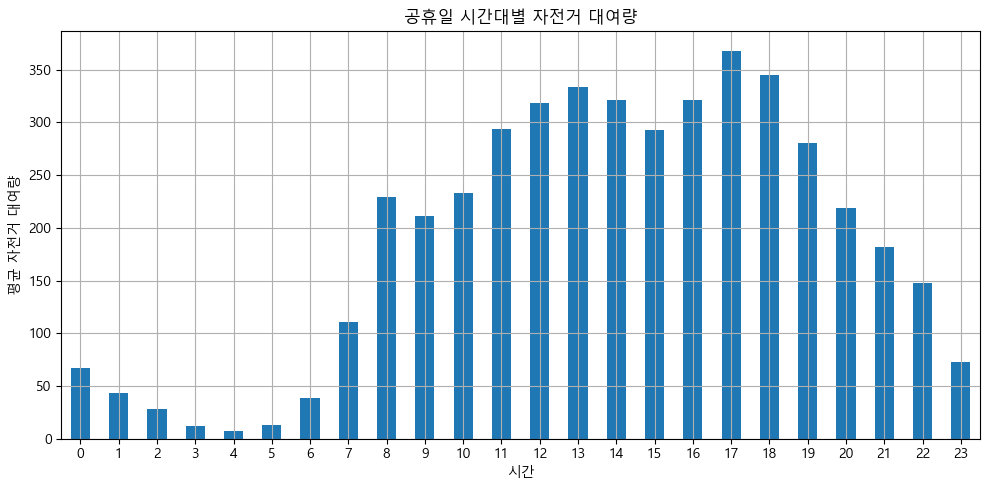

In [231]:
holiday_df = train_df[train_df['holiday'] == 1]
hourly_avg = holiday_df.groupby('hour')['count'].mean()
plt.figure(figsize=(10, 5))
hourly_avg.plot(kind='bar')
plt.title('공휴일 시간대별 자전거 대여량')
plt.xlabel('시간')
plt.ylabel('평균 자전거 대여량')
plt.grid(True)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

- 공휴일의 유무는 실제 그래프 상에서도 일을 하냐 안하냐의 유무의 그래프와 비슷한 패턴을 보였다
- 따라서 holiday 컬럼은 모델링에서 삭제한다

- 특정 시간대에서 보여주는 높은 자전거 대여량과의 상관 관계를 반영하고, 특정 시간대에서는 대여량이 현저히 낮고, 그리고 평균적인 대여량을 보여주는 오후 시간대를 모두 반영해서 시간의 구간을 나누고 원핫 인코딩을 한후 모델링에 반영한다
- 시간대를 5개의 구간으로 나누고 , 구간별 시간을 조금씩 다르게 조정한 type1, type2
- 시간대를 6개의 구간으로 나눈 type3 , 그리고 평균 대여량을 기준으로 그룹을 나눈 count 까지 총 4개의 구간을 나눌 기준을 마련해두고 각각 어느 구간이 좋은지 확인해본다
- 선형 회귀를 통해 확인해본다

In [236]:
# 1. 시간 구간 매핑 함수들
def hour_period_type1(hour):
    if hour <= 5:
        return 'LN'  # Late Night
    elif hour <= 9:
        return 'MR'  # Morning Rush
    elif hour <= 15:
        return 'Daytime'
    elif hour <= 19:
        return 'ER'  # Evening Rush
    else:
        return 'Night'

def hour_period_type2(hour):
    if hour <= 5:
        return 'D'
    elif hour <= 9:
        return 'MP'
    elif hour <= 16:
        return 'Daytime'
    elif hour <= 20:
        return 'EP'
    else:
        return 'LN'

def hour_period_type3(hour):
    if 0 <= hour <= 5:
        return 'Late Night'
    elif 6 <= hour <= 9:
        return 'Morning Peak'
    elif 10 <= hour <= 15:
        return 'Daytime'
    elif 16 <= hour <= 18:
        return 'Evening Peak'
    elif 19 <= hour <= 21:
        return 'Night'
    else:
        return 'Late Evening'

def group_by_count(hour):
    if hour in [17, 18]:
        return 'Peak'
    elif hour in [8, 16, 19]:
        return 'High'
    elif hour in [7, 9, 11, 12, 13, 14, 15, 20]:
        return 'Mid'
    elif hour in [10, 21, 22]:
        return 'Low'
    else:
        return 'Quiet'

In [238]:
# 2. 데이터 준비
#1 atemp 만
def prepare_df(df, hour_func):
    df = df.copy()
    df['hour_period'] = df['hour'].apply(hour_func)
    df = pd.get_dummies(df, columns=['hour_period'], dtype=int)

    # 기타 원핫 인코딩
    df['year'] = df['datetime'].dt.year
    df = pd.get_dummies(df, columns=['year', 'season', 'weather'], drop_first=False, dtype=int)
    # 불필요한 컬럼 제거
    df = df.drop(columns=['hour', 'temp','difference','difference_abs','holiday'])
    return df

In [2151]:
#2 temp 만
def prepare_df(df, hour_func):
    df = df.copy()
    df['hour_period'] = df['hour'].apply(hour_func)
    df = pd.get_dummies(df, columns=['hour_period'], dtype=int)
    

    # 기타 원핫 인코딩
    df['year'] = df['datetime'].dt.year
    df = pd.get_dummies(df, columns=['year', 'season', 'weather'], drop_first=False, dtype=int)
    # 불필요한 컬럼 제거
    df = df.drop(columns=['hour', 'atemp','difference','difference_abs','holiday'])
    return df

In [2155]:
#3 temp + atemp
def prepare_df(df, hour_func):
    df = df.copy()
    df['hour_period'] = df['hour'].apply(hour_func)
    df = pd.get_dummies(df, columns=['hour_period'], dtype=int)
    

    # 기타 원핫 인코딩
    df['year'] = df['datetime'].dt.year
    df = pd.get_dummies(df, columns=['year', 'season', 'weather'], drop_first=False, dtype=int)
    # 불필요한 컬럼 제거
    df = df.drop(columns=['hour','difference','difference_abs','holiday'])
    return df

In [2159]:
#4 atemp + differnet
def prepare_df(df, hour_func):
    df = df.copy()
    df['hour_period'] = df['hour'].apply(hour_func)
    df = pd.get_dummies(df, columns=['hour_period'], dtype=int)
    

    # 기타 원핫 인코딩
    df['year'] = df['datetime'].dt.year
    df = pd.get_dummies(df, columns=['year', 'season', 'weather'], drop_first=False, dtype=int)
    # 불필요한 컬럼 제거
    df = df.drop(columns=['hour', 'temp','difference_abs','holiday'])
    return df

In [2163]:
#5 atemp + differnet_abs
def prepare_df(df, hour_func):
    df = df.copy()
    df['hour_period'] = df['hour'].apply(hour_func)
    df = pd.get_dummies(df, columns=['hour_period'], dtype=int)  

    # 기타 원핫 인코딩
    df['year'] = df['datetime'].dt.year
    df = pd.get_dummies(df, columns=['year', 'season', 'weather'], drop_first=False, dtype=int)
    # 불필요한 컬럼 제거
    df = df.drop(columns=['hour', 'temp','difference','holiday'])
    return df

In [240]:
# 3. 입력 피처와 타겟 정의
def split_X_y(df):
    X = df.drop(columns=['datetime', 'registered', 'casual', 'count'])
    y = df[['count']]
    return X, y

In [242]:
# 4. 모델 학습 및 평가
def train_and_evaluate(X, y, degree=1):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    if degree > 1:
        poly = PolynomialFeatures(degree)
        X_scaled = poly.fit_transform(X_scaled)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=True)
    model = LinearRegression()
    model.fit(X_train, y_train)

    preds = np.maximum(0, model.predict(X_test))
    rmsle = np.sqrt(mean_squared_log_error(y_test, preds))
    return rmsle

# 5. 전체 실행
df_base = train_df.copy()

# 각 타입별 데이터프레임 생성
type_dfs = {
    "type_count": prepare_df(df_base, group_by_count),
    "type2": prepare_df(df_base, hour_period_type2),
    "type3": prepare_df(df_base, hour_period_type3),
    "type1": prepare_df(df_base, hour_period_type1)
}

# RMSLE 결과 비교
print("📊 선형회귀 RMSLE 비교 (기본 특성)")
for name, df in type_dfs.items():
    X, y = split_X_y(df)
    rmsle = train_and_evaluate(X, y)
    print(f"{name}: RMSLE = {rmsle:.8f}")

print("\n📊 선형회귀 RMSLE 비교 (다항 특성, 3차)")
for name, df in type_dfs.items():
    X, y = split_X_y(df)
    rmsle = train_and_evaluate(X, y, degree=3)
    print(f"{name} (poly): RMSLE = {rmsle:.8f}")

print(X.head(), "\n")

📊 선형회귀 RMSLE 비교 (기본 특성)
type_count: RMSLE = 1.16235292
type2: RMSLE = 1.17313703
type3: RMSLE = 1.15452613
type1: RMSLE = 1.13978000

📊 선형회귀 RMSLE 비교 (다항 특성, 3차)
type_count (poly): RMSLE = 0.91707970
type2 (poly): RMSLE = 0.82524654
type3 (poly): RMSLE = 0.81250423
type1 (poly): RMSLE = 0.82117322
   workingday   atemp  humidity  windspeed  hour_period_Daytime  \
0           0  14.395        81        0.0                    0   
1           0  13.635        80        0.0                    0   
2           0  13.635        80        0.0                    0   
3           0  14.395        75        0.0                    0   
4           0  14.395        75        0.0                    0   

   hour_period_ER  hour_period_LN  hour_period_MR  hour_period_Night  \
0               0               1               0                  0   
1               0               1               0                  0   
2               0               1               0                  0   
3         

- 다중 선형회귀, 다항회귀 를 사용해서 테스트했고, 1차 2차 보다 3차의 경우 평균적인 rmsle 값이 낮았다
- 우선 temp 와 atemp 둘다 같은조건에서 단독으로 사용했을때 temp 보단 atemp 즉 체감온도가 더 낮은 rmsle 값을 보여주었다
- 즉 실제 온도보다 체감온도가 자전거 대여량에 조금더 영향이 큼을 알수 있었다
- temp 와 atemp 컬럼 모두를 넣었을때는 하나만 넣었을때보다 평균적으로 높은 rmsle 값이 나왔고, 비슷한 컬럼은 삭제를 해주는것이 더 좋은 결과값을 얻을수 있다는 사실을 알게 되었다
- 여러 Test를 해본 결과 type3번 슬라이싱을 사용하고, atemp 컬럼을 넣고, temp, different, differenet_abs, holiday 컬럼 모두 버리는것이 가장 낮은 rmsle 값을 얻을수 있었다.

In [245]:
type3_df = prepare_df(train_df.copy(), hour_period_type3)

In [247]:
type3_df.head()

,datetime,workingday,atemp,humidity,windspeed,casual,registered,count,hour_period_Daytime,hour_period_Evening Peak,hour_period_Late Evening,hour_period_Late Night,hour_period_Morning Peak,hour_period_Night,year_2011,year_2012,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3
0,2011-01-01 00:00:00,0,14.395,81,0.0,3,13,16,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0
1,2011-01-01 01:00:00,0,13.635,80,0.0,8,32,40,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0
2,2011-01-01 02:00:00,0,13.635,80,0.0,5,27,32,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0
3,2011-01-01 03:00:00,0,14.395,75,0.0,3,10,13,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0
4,2011-01-01 04:00:00,0,14.395,75,0.0,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0


In [249]:
y = type3_df['count']

In [251]:
type3_df.head()

,datetime,workingday,atemp,humidity,windspeed,casual,registered,count,hour_period_Daytime,hour_period_Evening Peak,hour_period_Late Evening,hour_period_Late Night,hour_period_Morning Peak,hour_period_Night,year_2011,year_2012,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3
0,2011-01-01 00:00:00,0,14.395,81,0.0,3,13,16,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0
1,2011-01-01 01:00:00,0,13.635,80,0.0,8,32,40,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0
2,2011-01-01 02:00:00,0,13.635,80,0.0,5,27,32,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0
3,2011-01-01 03:00:00,0,14.395,75,0.0,3,10,13,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0
4,2011-01-01 04:00:00,0,14.395,75,0.0,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0


In [253]:
X = type3_df.drop(columns=['datetime','casual', 'registered','count'])

In [257]:
X.head()

,workingday,atemp,humidity,windspeed,hour_period_Daytime,hour_period_Evening Peak,hour_period_Late Evening,hour_period_Late Night,hour_period_Morning Peak,hour_period_Night,year_2011,year_2012,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3
0,0,14.395,81,0.0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0
1,0,13.635,80,0.0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0
2,0,13.635,80,0.0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0
3,0,14.395,75,0.0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0
4,0,14.395,75,0.0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0


In [303]:
scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X)
polynomial_transformer = PolynomialFeatures(3)
X_poly = polynomial_transformer.fit_transform(X_scaled)
X_train, X_test, y_train, y_test = train_test_split(X_poly,y, test_size=0.2, random_state=42)
model = LinearRegression()

In [305]:
model.fit(X_train, y_train)

LinearRegression()

In [307]:
y_test_prediction = model.predict(X_test)
y_test_prediction = np.maximum(0, y_test_prediction)

In [309]:
rmsle = np.sqrt(mean_squared_log_error(y_test, y_test_prediction))
print("RMSLE:", rmsle)

RMSLE: 0.8125042317803439


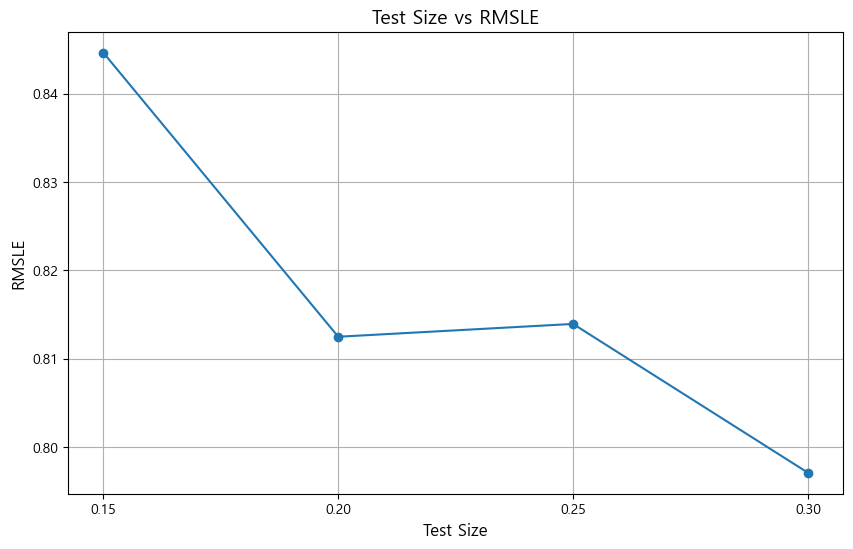

In [1383]:
# test 사이즈 별 RMSLE
test_sizes = np.round(np.arange(0.15, 0.301, 0.05), 2)
rmsles = []

for size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(
        X_poly, y, test_size=size, random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = np.maximum(0, model.predict(X_test))
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    rmsles.append(rmsle)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(test_sizes, rmsles, marker='o')
plt.title("Test Size vs RMSLE", fontsize=14)
plt.xlabel("Test Size", fontsize=12)
plt.ylabel("RMSLE", fontsize=12)
plt.grid(True)
plt.xticks(test_sizes)
plt.show()

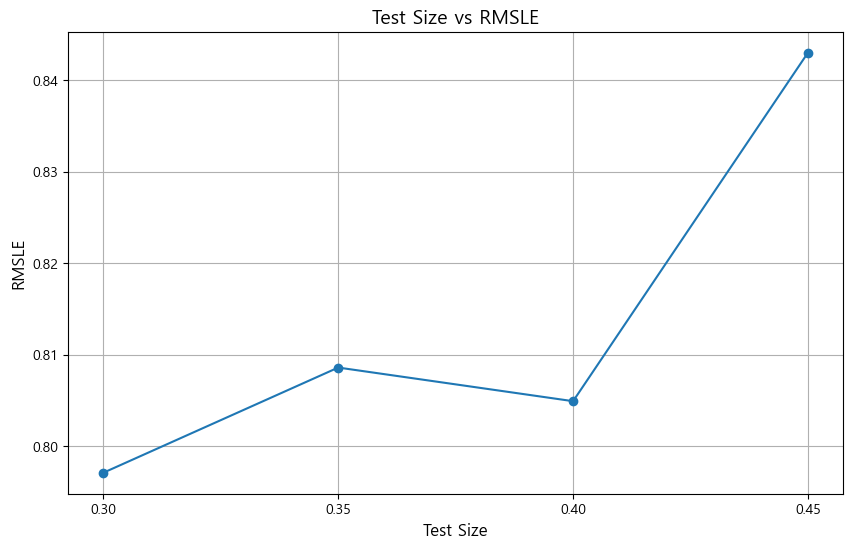

In [1387]:
test_sizes = np.round(np.arange(0.3, 0.5, 0.05), 3)
rmsles = []

for size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(
        X_poly, y, test_size=size, random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = np.maximum(0, model.predict(X_test))
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    rmsles.append(rmsle)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(test_sizes, rmsles, marker='o')
plt.title("Test Size vs RMSLE", fontsize=14)
plt.xlabel("Test Size", fontsize=12)
plt.ylabel("RMSLE", fontsize=12)
plt.grid(True)
plt.xticks(test_sizes)
plt.show()

- Test Size 0.3일때 가장 RMSLE 값이 낮다

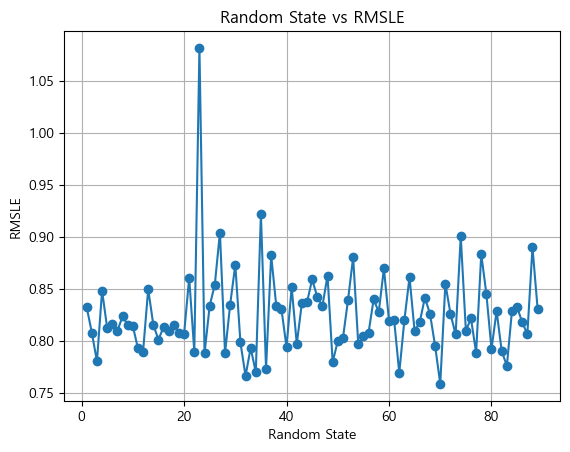

 최저 RMSLE: 0.75875 at random_state = 70


In [1390]:
random_states = range(1,90)
rmsles = []

for rs in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.30, random_state=rs)
    model.fit(X_train, y_train)
    y_pred = np.maximum(0, model.predict(X_test))
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    rmsles.append(rmsle)

# 시각화
plt.plot(random_states, rmsles, marker='o')
plt.xlabel("Random State")
plt.ylabel("RMSLE")
plt.title("Random State vs RMSLE")
plt.grid(True)
plt.show()

# 최저 RMSLE 값과 해당 random_state 찾기
min_rmsle = min(rmsles)
best_rs = random_states[rmsles.index(min_rmsle)]

print(f" 최저 RMSLE: {min_rmsle:.5f} at random_state = {best_rs}")

- random_state = 70로 설정

In [291]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.30, random_state=70)

In [2248]:
# 정규화 (Lasso)
model = Lasso(alpha=0.1, max_iter=2000) 
model.fit(X_train, y_train)

y_test_prediction = model.predict(X_test)
y_test_prediction = np.maximum(0, y_test_prediction)

rmsle = np.sqrt(mean_squared_log_error(y_test, y_test_prediction))
print("RMSLE (Lasso alpha=0.1):", rmsle)

RMSLE (Lasso alpha=0.1): 0.7617569389558506


In [1418]:
# alpha 값 미세 조정

alphas = [0.005, 0.01, 0.05, 0.1, 0.5, 1, 5]
for alpha in alphas:
    model = Lasso(alpha=alpha, max_iter=10000)
    model.fit(X_train, y_train)
    y_pred = np.maximum(0, model.predict(X_test))
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    print(f"RMSLE (Lasso alpha={alpha}): {rmsle:.5f}")

C:\Users\82104\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.014e+05, tolerance: 2.450e+04
  model = cd_fast.enet_coordinate_descent(


RMSLE (Lasso alpha=0.005): 0.74990
RMSLE (Lasso alpha=0.01): 0.73732
RMSLE (Lasso alpha=0.05): 0.75096
RMSLE (Lasso alpha=0.1): 0.76176
RMSLE (Lasso alpha=0.5): 0.80426
RMSLE (Lasso alpha=1): 0.84264
RMSLE (Lasso alpha=5): 0.98888


In [1422]:
# alpha 값 미세 조정

alphas = [0.03,0.04,0.05,0.06]
for alpha in alphas:
    model = Lasso(alpha=alpha, max_iter=5000)
    model.fit(X_train, y_train)
    y_pred = np.maximum(0, model.predict(X_test))
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    print(f"RMSLE (Lasso alpha={alpha}): {rmsle:.5f}")

RMSLE (Lasso alpha=0.03): 0.73458
RMSLE (Lasso alpha=0.04): 0.74976
RMSLE (Lasso alpha=0.05): 0.75096
RMSLE (Lasso alpha=0.06): 0.75370


C:\Users\82104\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.014e+05, tolerance: 2.450e+04
  model = cd_fast.enet_coordinate_descent(


RMSLE (Lasso alpha=0.005): 0.74990
RMSLE (Lasso alpha=0.01): 0.73732
RMSLE (Lasso alpha=0.02): 0.73011
RMSLE (Lasso alpha=0.03): 0.73458


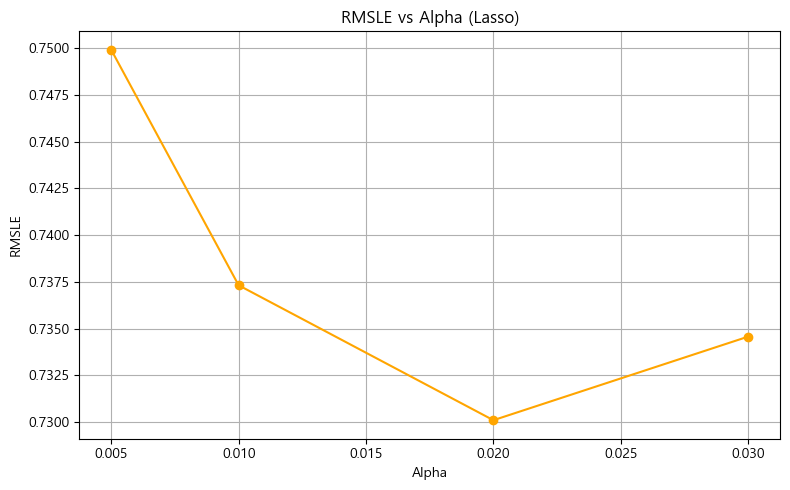

In [2250]:
# alpha 리스트
alphas = [0.005, 0.01, 0.02 , 0.03]
rmsle_scores = []

# alpha 값에 따라 Lasso 회귀 실행
for alpha in alphas:
    model = Lasso(alpha=alpha, max_iter=10000)
    model.fit(X_train, y_train)
    y_pred = np.maximum(0, model.predict(X_test))  # 음수 방지
    y_test_clipped = np.maximum(0, y_test)
    rmsle = np.sqrt(mean_squared_log_error(y_test_clipped, y_pred))
    rmsle_scores.append(rmsle)
    print(f"RMSLE (Lasso alpha={alpha}): {rmsle:.5f}")

# 그래프 시각화
plt.figure(figsize=(8, 5))
plt.plot(alphas, rmsle_scores, marker='o', color='orange')
plt.title("RMSLE vs Alpha (Lasso)")
plt.xlabel("Alpha")
plt.ylabel("RMSLE")
plt.grid(True)
plt.tight_layout()
plt.show()

- alpha 값이 0.02에서 가자 좋은 성능을 보이지만 시간이 오래 걸림

In [1429]:
# 정규화 (Ridge)
from sklearn.linear_model import Ridge

alphas = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0,10]
for alpha in alphas:
    model = Ridge(alpha=alpha, max_iter=2000)
    model.fit(X_train, y_train)
    y_pred = np.maximum(0, model.predict(X_test))
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    print(f"RMSLE (Ridge alpha={alpha}): {rmsle:.5f}")

RMSLE (Ridge alpha=0.01): 0.77527
RMSLE (Ridge alpha=0.05): 0.77354
RMSLE (Ridge alpha=0.1): 0.77284
RMSLE (Ridge alpha=0.5): 0.75828
RMSLE (Ridge alpha=1.0): 0.74739
RMSLE (Ridge alpha=5.0): 0.73684
RMSLE (Ridge alpha=10): 0.74010


In [1524]:
alphas = np.arange(3, 7, 0.1)
for alpha in alphas:
    model = Ridge(alpha=alpha, max_iter=300)
    model.fit(X_train, y_train)
    y_pred = np.maximum(0, model.predict(X_test))
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    print(f"RMSLE (Ridge alpha={alpha}): {rmsle:.5f}")

RMSLE (Ridge alpha=3.0): 0.73496
RMSLE (Ridge alpha=3.1): 0.73493
RMSLE (Ridge alpha=3.2): 0.73487
RMSLE (Ridge alpha=3.3000000000000003): 0.73487
RMSLE (Ridge alpha=3.4000000000000004): 0.73486
RMSLE (Ridge alpha=3.5000000000000004): 0.73470
RMSLE (Ridge alpha=3.6000000000000005): 0.73459
RMSLE (Ridge alpha=3.7000000000000006): 0.73457
RMSLE (Ridge alpha=3.8000000000000007): 0.73465
RMSLE (Ridge alpha=3.900000000000001): 0.73479
RMSLE (Ridge alpha=4.000000000000001): 0.73487
RMSLE (Ridge alpha=4.100000000000001): 0.73502
RMSLE (Ridge alpha=4.200000000000001): 0.73521
RMSLE (Ridge alpha=4.300000000000001): 0.73547
RMSLE (Ridge alpha=4.400000000000001): 0.73580
RMSLE (Ridge alpha=4.500000000000002): 0.73600
RMSLE (Ridge alpha=4.600000000000001): 0.73618
RMSLE (Ridge alpha=4.700000000000001): 0.73637
RMSLE (Ridge alpha=4.800000000000002): 0.73657
RMSLE (Ridge alpha=4.900000000000002): 0.73672
RMSLE (Ridge alpha=5.000000000000002): 0.73684
RMSLE (Ridge alpha=5.100000000000001): 0.73696
RM

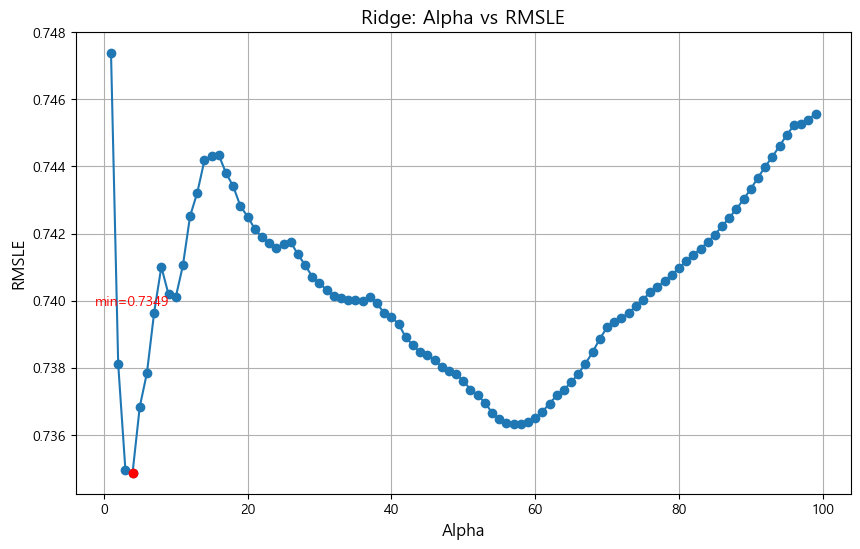

최소 RMSLE: 0.73487 at alpha = 4.0


In [1433]:
alphas = np.arange(1, 100, 1.0)
rmsles = []

for alpha in alphas:
    model = Ridge(alpha=alpha, max_iter=2000)
    model.fit(X_train, y_train)
    y_pred = np.maximum(0, model.predict(X_test))
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    rmsles.append(rmsle)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(alphas, rmsles, marker='o')
plt.title("Ridge: Alpha vs RMSLE", fontsize=14)
plt.xlabel("Alpha", fontsize=12)
plt.ylabel("RMSLE", fontsize=12)
plt.grid(True)

# 최저점 표시
min_rmsle = min(rmsles)
best_alpha = alphas[rmsles.index(min_rmsle)]
plt.scatter(best_alpha, min_rmsle, color='red', zorder=5)
plt.text(best_alpha, min_rmsle + 0.005, f"min={min_rmsle:.4f}", ha='center', color='red')

plt.show()
print(f"최소 RMSLE: {min_rmsle:.5f} at alpha = {best_alpha}")

In [2255]:
model = Ridge(alpha=3.7, max_iter=2000)
model.fit(X_train, y_train)
y_pred = np.maximum(0, model.predict(X_test))
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
print(rmsle)
# RMSLE (Ridge alpha=3.7000000000000006): 0.73457
# print("반복 횟수:", model.n_iter_)

0.7345719920996977


In [2252]:
# ElasticNet 
from sklearn.linear_model import ElasticNet

alphas = [0.02]
l1_ratios = np.linspace(0.1, 1.0, 10)  # Lasso vs Ridge 비중

for alpha in alphas:
    for l1_ratio in l1_ratios:
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)
        model.fit(X_train, y_train)
        y_pred = np.maximum(0, model.predict(X_test))
        rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
        print(f"RMSLE (alpha={alpha}, l1_ratio={l1_ratio}): {rmsle:.5f}")

RMSLE (alpha=0.02, l1_ratio=0.1): 0.75449
RMSLE (alpha=0.02, l1_ratio=0.2): 0.75071
RMSLE (alpha=0.02, l1_ratio=0.30000000000000004): 0.74781
RMSLE (alpha=0.02, l1_ratio=0.4): 0.74527
RMSLE (alpha=0.02, l1_ratio=0.5): 0.74232
RMSLE (alpha=0.02, l1_ratio=0.6): 0.73843
RMSLE (alpha=0.02, l1_ratio=0.7000000000000001): 0.73604
RMSLE (alpha=0.02, l1_ratio=0.8): 0.73624
RMSLE (alpha=0.02, l1_ratio=0.9): 0.73950
RMSLE (alpha=0.02, l1_ratio=1.0): 0.73011


- Lasso : RMSLE (alpha=0.02, l1_ratio=1.0) -> 0.73011
- Ridge : RMSLE ( alpha = 3.7) -> 0.734571
- ElasticNet : Lasso의 비율이 늘어날수록 데이터 수치가 좋아졌음
- Lasso가 수치상으로는 가장 좋았지만 시간이 오래 걸린다는 단점이 있음

In [ ]:
# k겹 교차 검증

In [2290]:
model = Ridge(alpha=3.7, max_iter=1000)

k_fold_score = np.average(cross_val_score(model, X_poly, y , cv=5))
k_fold_score


0.6065050542153869

In [2262]:
k_fold_score = np.average(cross_val_score(model, X_poly, y , cv=4))
k_fold_score

0.6403054843427942

In [2264]:
k_fold_score = np.average(cross_val_score(model, X_poly, y , cv=3))
k_fold_score

0.6954256235256139

In [2266]:
k_fold_score = np.average(cross_val_score(model, X_poly, y , cv=2))
k_fold_score

0.39109481151918

In [2268]:
model = Lasso(alpha=0.02, max_iter=10000)
k_fold_score = np.average(cross_val_score(model, X_poly, y , cv=5))
k_fold_score

0.5485433548392922

- k_fold_score 가 의미 하는 값은 R**2
- 1에 가까울수록 모델이 데이터를 잘 설명
- 0이면 기본 평균 수준과 같음

In [277]:
from sklearn.model_selection import KFold

# 넘파이 배열로 변환
y_array = y.to_numpy()
alpha_val = 3.7
model = Ridge(alpha=alpha_val, max_iter=100)

# 다양한 CV 설정
cv_values = [3,4,5,6]
cv_rmsle_results = {}

for cv in cv_values:
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    rmsle_scores = []

    for train_idx, val_idx in kf.split(X_poly):
        X_train_fold, X_val_fold = X_poly[train_idx], X_poly[val_idx]
        y_train_fold, y_val_fold = y_array[train_idx], y_array[val_idx]  
        
        model.fit(X_train_fold, y_train_fold)
        y_pred = np.maximum(0, model.predict(X_val_fold))
        y_val_fixed = np.maximum(0, y_val_fold)

        rmsle = np.sqrt(mean_squared_log_error(y_val_fixed, y_pred))
        rmsle_scores.append(rmsle)

    mean_rmsle = np.mean(rmsle_scores)
    cv_rmsle_results[cv] = mean_rmsle
    print(f"✅ RMSLE (cv={cv}): {mean_rmsle:.5f}")

✅ RMSLE (cv=3): 0.76760
✅ RMSLE (cv=4): 0.75159
✅ RMSLE (cv=5): 0.75894
✅ RMSLE (cv=6): 0.75582


In [2284]:
# 넘파이 배열로 변환
y_array = y.to_numpy()
alpha_val = 0.02
model = Lasso(alpha=alpha_val, max_iter=10000)

# 다양한 CV 설정
cv_values = [3, 4, 5, 6]
cv_rmsle_results = {}

for cv in cv_values:
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    rmsle_scores = []

    for train_idx, val_idx in kf.split(X_poly):
        X_train_fold, X_val_fold = X_poly[train_idx], X_poly[val_idx]
        y_train_fold, y_val_fold = y_array[train_idx], y_array[val_idx]  # ✅ 이 부분 수정

        model.fit(X_train_fold, y_train_fold)
        y_pred = np.maximum(0, model.predict(X_val_fold))
        y_val_fixed = np.maximum(0, y_val_fold)

        rmsle = np.sqrt(mean_squared_log_error(y_val_fixed, y_pred))
        rmsle_scores.append(rmsle)

    mean_rmsle = np.mean(rmsle_scores)
    cv_rmsle_results[cv] = mean_rmsle
    print(f"✅ RMSLE (cv={cv}): {mean_rmsle:.5f}")

✅ RMSLE (cv=3): 0.76548
✅ RMSLE (cv=4): 0.75374
✅ RMSLE (cv=5): 0.75813
✅ RMSLE (cv=6): 0.75488


- k fold cross validation 수행 결과 평균적인 성능 차이가 ridge 와 lasso 둘다 크게 나지 않음
- 반면에 프로그램 실행 속도는 ridge가 월등히 빠름

In [339]:
# 그리드 리서치

hyper_parameters = {
    'alpha': [0,100,198,199, 200 ,500,1000], 
    'max_iter': [100]   
}

# 2. 모델 선언
model = Ridge()

# 3. 그리드서치 객체 생성
grid_search = GridSearchCV(model, hyper_parameters, cv=4)

# 4. 모델 학습
grid_search.fit(X_poly, y)

# 5. 최적 하이퍼파라미터 출력
best_params = grid_search.best_params_
print("최적 하이퍼파라미터:", best_params)

# 6. 성능 확인
from sklearn.metrics import mean_squared_log_error
best_model = grid_search.best_estimator_
preds = best_model.predict(X_poly)
preds = np.maximum(0, preds)
rmsle = np.sqrt(mean_squared_log_error(y, preds))
print(f"RMSLE (Best Ridge): {rmsle:.5f}")

최적 하이퍼파라미터: {'alpha': 199, 'max_iter': 100}
RMSLE (Best Ridge): 0.76791


In [389]:
# 그리드 리서치

hyper_parameters = {
    'alpha': [3.7,32,33,34,100], 
    'max_iter': [100]   
}

# 2. 모델 선언
model = Ridge()

# 3. 그리드서치 객체 생성
grid_search = GridSearchCV(model, hyper_parameters, cv=3)

# 4. 모델 학습
grid_search.fit(X_poly, y)

# 5. 최적 하이퍼파라미터 출력
best_params = grid_search.best_params_
print("최적 하이퍼파라미터:", best_params)

# 6. 성능 확인
from sklearn.metrics import mean_squared_log_error
best_model = grid_search.best_estimator_
preds = best_model.predict(X_poly)
preds = np.maximum(0, preds)
rmsle = np.sqrt(mean_squared_log_error(y, preds))
print(f"RMSLE (Best Ridge): {rmsle:.5f}")

최적 하이퍼파라미터: {'alpha': 33, 'max_iter': 100}
RMSLE (Best Ridge): 0.73825


- Ridge가 Solver를 사용했기때문에 max_iter값을 낮게 줘도 괜찮음
- 앞서 조사한 alpha(3.7)이 가장 최소의 rmsle를 보여주었지만, k fold cross validation 을 적용할 경우
- fold = 4 : alpha = 199인경우 가장 최적의 모델 RMSLE (Best Ridge): 0.76791
- fold = 3 : alpha = 33인 경우 가장 최적의 모델 RMSLE (Best Ridge): 0.76791  

In [390]:
best_model = grid_search.best_estimator_
best_model.fit(X_poly, y)
preds = np.maximum(0, best_model.predict(X_poly))
rmsle = np.sqrt(mean_squared_log_error(y, preds))
print(f"RMSLE (Best Ridge): {rmsle:.5f}")

RMSLE (Best Ridge): 0.73825
